# Spatial-Temporal Graph Neural Network (Spatial-Temporal GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using a Pose Estimation network in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [ ]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

# Dataset

## Training dataset

In [2]:
datasetName = 'JAAD'
subset = 'train'
poseEstimator = 'AlphaPose' #'OpenPose'
info = 87
numberOfJoints = 25 if poseEstimator == 'OpenPose' else 18

train_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + '.csv',
                           normalization='minmax', target='cross', info=info,
                           remove_undetected=True, numberOfJoints=numberOfJoints)

print('train_dataset len:', len(train_dataset))
print('Temporal dimension length:', len(train_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', train_dataset.data[0].x_temporal[0].shape)

train_dataset.loadedData

train_dataset len: 13407
Temporal dimension length: 87
Shape of each skeletons data (x): torch.Size([18, 3])


video  frame       ped_id  \
0      video_0001      0       0_1_3b   
1      video_0001      1       0_1_3b   
2      video_0001      2       0_1_3b   
3      video_0001      3       0_1_3b   
4      video_0001      4       0_1_3b   
...           ...    ...          ...   
61800  video_0345    132  0_345_2700b   
61801  video_0345    133  0_345_2700b   
61802  video_0345    134  0_345_2700b   
61803  video_0345    135  0_345_2700b   
61804  video_0345    136  0_345_2700b   

                                                skeleton  skeleton_detected  \
0      [[527.3912353515625, 751.2621459960938, 0.7392...               True   
1      [[523.9093017578125, 752.7357177734375, 0.7035...               True   
2      [[1453.533935546875, 678.0730590820312, 0.9457...               True   
3      [[520.5011596679688, 752.8726196289062, 0.7747...               True   
4      [[1459.4296875, 681.8412475585938, 0.931000173...               True   
...                                                  ...                ...   
61800  [[29.07973289489746, 625.244140625, 0.05306298...               True   
61801  [[22.0767765045166, 584.6350708007812, 0.65492...               True   
61802  [[14.360211372375488, 603.4249267578125, 0.283...               True   
61803  [[9.5849609375, 637.0150756835938, 0.453891694...               True   
61804  [[14.74562931060791, 658.5490112304688, 0.7406...               True   

              cross       reaction   hand_gesture         look    action  \
0      not-crossing  __undefined__  __undefined__  not-looking  standing   
1      not-crossing  __undefined__  __undefined__  not-looking  standing   
2      not-crossing  __undefined__  __undefined__  not-looking  standing   
3      not-crossing  __undefined__  __undefined__  not-looking  standing   
4      not-crossing  __undefined__  __undefined__  not-looking  standing   
...             ...            ...            ...          ...       ...   
61800  not-crossing  __undefined__  __undefined__  not-looking   walking   
61801  not-crossing  __undefined__  __undefined__  not-looking   walking   
61802  not-crossing  __undefined__  __undefined__  not-looking   walking   
61803  not-crossing  __undefined__  __undefined__  not-looking   walking   
61804  not-crossing  __undefined__  __undefined__  not-looking   walking   

                 nod occlusion                          bbox  bbox_center_x  \
0      __undefined__      none  [465.0, 730.0, 533.0, 848.0]          499.0   
1      __undefined__      none  [463.0, 730.0, 532.0, 848.0]          497.5   
2      __undefined__      none  [461.0, 730.0, 531.0, 849.0]          496.0   
3      __undefined__      none  [459.0, 730.0, 530.0, 849.0]          494.5   
4      __undefined__      none  [458.0, 731.0, 530.0, 851.0]          494.0   
...              ...       ...                           ...            ...   
61800  __undefined__      part   [3.0, 585.0, 157.0, 1046.0]           80.0   
61801  __undefined__      part   [3.0, 597.0, 137.0, 1022.0]           70.0   
61802  __undefined__      part    [3.0, 614.0, 117.0, 993.0]           60.0   
61803  __undefined__      part     [3.0, 636.0, 96.0, 960.0]           49.5   
61804  __undefined__      part     [3.0, 662.0, 74.0, 922.0]           38.5   

       bbox_center_y  skeleton_center_x  skeleton_center_y  
0              789.0         505.166349         774.751916  
1              789.0         502.850274         775.266100  
2              789.5        1448.740197         742.659351  
3              789.5         498.565045         774.777420  
4              791.0        1455.189830         743.797670  
...              ...                ...                ...  
61800          815.5          50.422588         787.651923  
61801          809.5          39.776443         770.073103  
61802          803.5          25.795314         781.366279  
61803          798.0          26.987405         767.314585  
61804          792.0          22.3769

Important columns:

In [3]:
train_dataset.loadedData[['video','frame','skeleton','skeleton_detected','cross']]

video  frame                                           skeleton  \
0      video_0001      0  [[527.3912353515625, 751.2621459960938, 0.7392...   
1      video_0001      1  [[523.9093017578125, 752.7357177734375, 0.7035...   
2      video_0001      2  [[1453.533935546875, 678.0730590820312, 0.9457...   
3      video_0001      3  [[520.5011596679688, 752.8726196289062, 0.7747...   
4      video_0001      4  [[1459.4296875, 681.8412475585938, 0.931000173...   
...           ...    ...                                                ...   
61800  video_0345    132  [[29.07973289489746, 625.244140625, 0.05306298...   
61801  video_0345    133  [[22.0767765045166, 584.6350708007812, 0.65492...   
61802  video_0345    134  [[14.360211372375488, 603.4249267578125, 0.283...   
61803  video_0345    135  [[9.5849609375, 637.0150756835938, 0.453891694...   
61804  video_0345    136  [[14.74562931060791, 658.5490112304688, 0.7406...   

       skeleton_detected         cross  
0                   True  not-crossing  
1                   True  not-crossing  
2                   True  not-crossing  
3                   True  not-crossing  
4                   True  not-crossing  
...                  ...           ...  
61800               True  not-crossing  
61801               True  not-crossing  
61802               True  not-crossing  
61803               True  not-crossing  
61804               True  not-crossing  

[60834 rows x 5 columns]

Number of elements per class:

Training dataset total rows: 60834
Training dataset crossing class samples: 35564
Training dataset not-crossing class samples: 25270


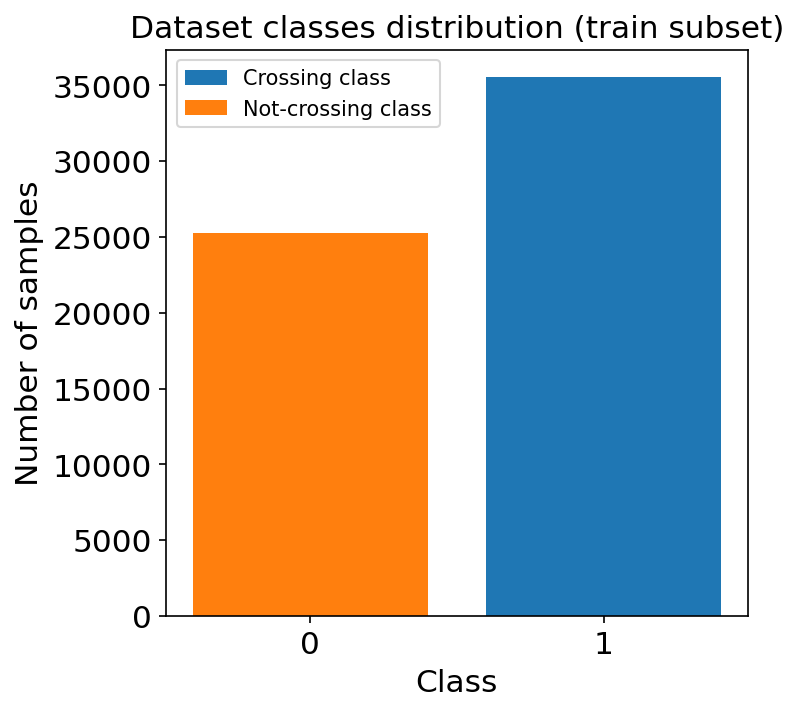

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']!='crossing'])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (train subset)', size=15)
plt.show()

## Validation dataset

In [5]:
subset = 'val'

val_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + '.csv',
                           normalization='minmax', target='cross', info=info,
                           remove_undetected=True, numberOfJoints=numberOfJoints)

In [6]:
print('val_dataset len:', len(val_dataset))
print('Temporal dimension length:', len(val_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', val_dataset.data[0].x_temporal[0].shape)

val_dataset len: 2213
Temporal dimension length: 87
Shape of each skeletons data (x): torch.Size([18, 3])


Important columns:

In [7]:
val_dataset.loadedData[['video','frame','skeleton','skeleton_detected','cross']].head(10)

video  frame                                           skeleton  \
0  video_0006      0  [[897.4727172851562, 720.0595703125, 0.3848784...   
1  video_0006      1  [[897.4951782226562, 720.0362548828125, 0.3810...   
2  video_0006      2  [[896.587158203125, 718.1592407226562, 0.28576...   
3  video_0006      3  [[896.0133056640625, 719.7392578125, 0.3119539...   
4  video_0006      4  [[894.0762329101562, 721.4017333984375, 0.4980...   
5  video_0006      5  [[893.3912963867188, 721.2113037109375, 0.4019...   
6  video_0006      6  [[1049.799072265625, 731.6937255859375, 0.1670...   
7  video_0006      7  [[898.4447021484375, 723.4312744140625, 0.2557...   
8  video_0006      8  [[891.2755126953125, 720.154541015625, 0.29131...   
9  video_0006      9  [[890.40771484375, 719.7791748046875, 0.256414...   

   skeleton_detected         cross  
0               True  not-crossing  
1               True  not-crossing  
2               True  not-crossing  
3               True  not-crossing  
4               True  not-crossing  
5               True  not-crossing  
6               True  not-crossing  
7               True  not-crossing  
8               True  not-crossing  
9               True  not-crossing

Number of elements per class:

Validation dataset total rows: 9482
Validation dataset crossing class samples: 5213
Validation dataset not-crossing class samples: 4269


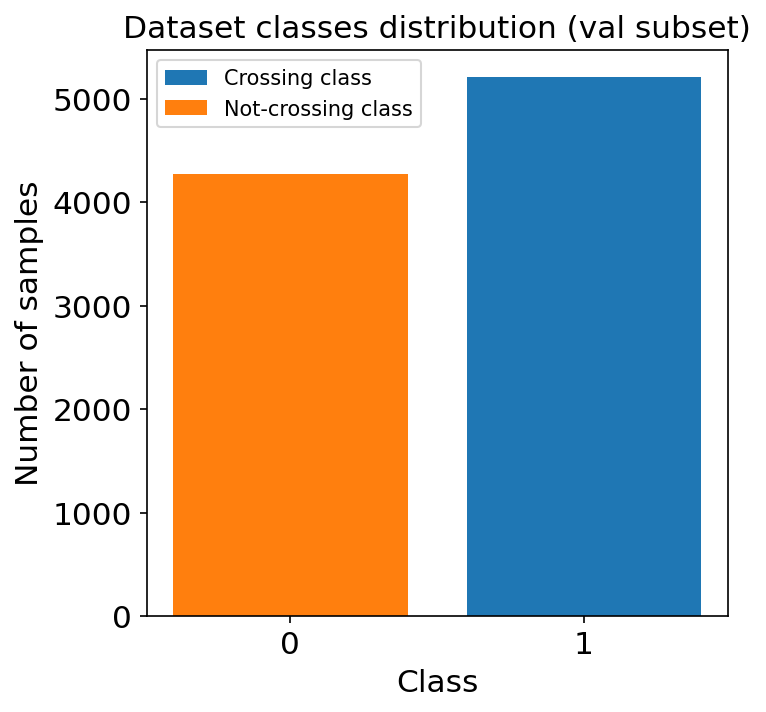

In [8]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']!='crossing'])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (val subset)', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

# Training

In [9]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x_temporal[0]

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 18
Number of features per node: 3


In [10]:
net = 'TGCN'
dropout = 0.5
num_epochs = 100
batch_size = 10000

numberOfClasses = 2

device = torch.device('cuda')
model = SpatialTemporalGNN(embed_dim, numberOfClasses, numberOfNodes, net=net,
                           filterSize=embed_dim, dropout=dropout, compute_explainability=True).to(device)

modelName = net + '_' + poseEstimator + '_info=' + str(info) + '_dropout=' + str(dropout)
modelName = modelName + '_epoch=' + str(num_epochs)

print('Loading model:', modelName)

model.load_state_dict(torch.load('exportedModels/' + datasetName + '/' + modelName))
model.eval()

Loading model: TGCN_AlphaPose_info=87_dropout=0.5_epoch=100


SpatialTemporalGNN(
  (conv1): TGCN(
    (conv_z): GCNConv(3, 3)
    (linear_z): Linear(in_features=6, out_features=3, bias=True)
    (conv_r): GCNConv(3, 3)
    (linear_r): Linear(in_features=6, out_features=3, bias=True)
    (conv_h): GCNConv(3, 3)
    (linear_h): Linear(in_features=6, out_features=3, bias=True)
  )
  (conv2): TGCN(
    (conv_z): GCNConv(3, 3)
    (linear_z): Linear(in_features=6, out_features=3, bias=True)
    (conv_r): GCNConv(3, 3)
    (linear_r): Linear(in_features=6, out_features=3, bias=True)
    (conv_h): GCNConv(3, 3)
    (linear_h): Linear(in_features=6, out_features=3, bias=True)
  )
  (lin1): Linear(in_features=54, out_features=27, bias=True)
  (lin2): Linear(in_features=27, out_features=13, bias=True)
  (lin3): Linear(in_features=13, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
  (dropout7): Dropout(p=0.7, inplace=F

# Testing

## Test dataset

In [11]:
subset = 'test'

test_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + '.csv',
                           normalization='minmax', target='cross', info=info,
                           remove_undetected=True, numberOfJoints=numberOfJoints)

Number of elements per class:

Test dataset total rows: 52485
Test dataset crossing class samples: 29484
Test dataset not-crossing class samples: 23001


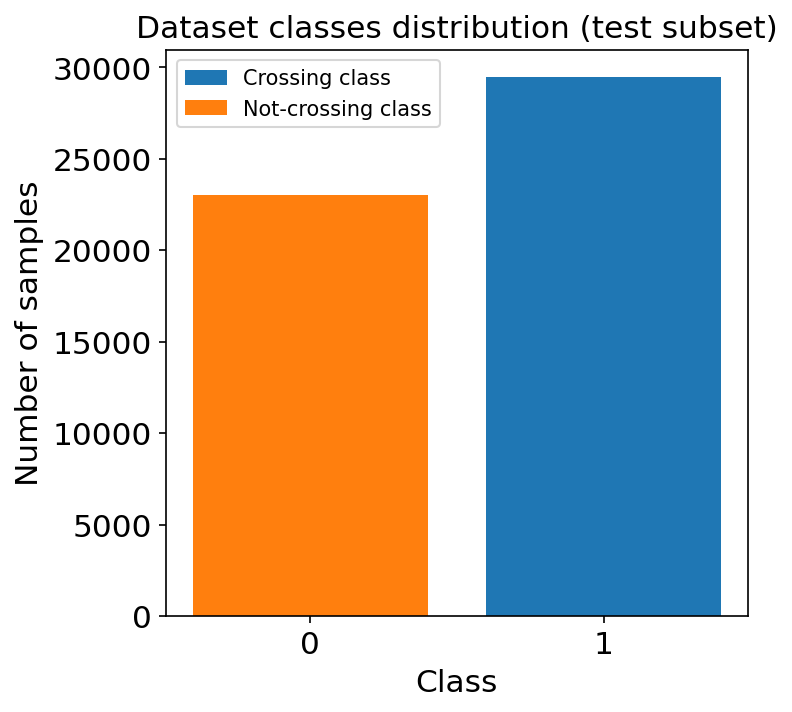

In [12]:
totalRows = len(test_dataset.loadedData)
crossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']!='crossing'])

print('Test dataset total rows:', totalRows)
print('Test dataset crossing class samples:', crossingRows)
print('Test dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (test subset)', size=15)
plt.show()

## Test results

In [13]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_metrics = evaluate(model, test_loader, device)


print_evaluation_test(test_metrics)

Testing subset results:

Accuracy:                 0.7604
Balanced accuracy:        0.6531
Precision:                0.7993
Recall:                   0.8931
f1-score:                 0.8436
 




# Explainability analysis

In [14]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
crit = torch.nn.BCELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

body_parts = list(train_dataset.body_parts.keys())

model.train()

skeletons = np.zeros((0, 18, 3))
heatmaps = np.zeros((0, 18))
labels = np.zeros((0))

for i, data in enumerate(train_loader):

    data = data.to(device)
    optimizer.zero_grad()

    output = model(data)

    label = data.y.to(device)

    label = reshape(label, (output.shape[0], output.shape[1]))

    loss = crit(output, label)

    loss.backward()
    
    acts = model.last_conv_act
    grads = model.last_conv_act.grad
    
    mean_grad_per_feature = torch.mean(grads, axis=0)
    heatmap_nodes = torch.relu(acts @ mean_grad_per_feature).detach().cpu().numpy()
        
    batch_skeletons = data.x_temporal[0].detach().cpu().numpy()
        
    skeletons = np.concatenate((skeletons, batch_skeletons.reshape(batch_skeletons.shape[0]//18, 18, 3)), axis=0)
    heatmaps = np.concatenate((heatmaps, heatmap_nodes.reshape(heatmap_nodes.shape[0]//18, 18)), axis=0)
    labels = np.concatenate((labels, data.label.detach().cpu().numpy()), axis=0)

In [15]:
def show_grad_cam(skeletonID, skeleton, heatmaps):
    
    figsize = 10
    dpi = 150
    fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize), dpi=dpi)

    node_coords = {}
    
    heatmap = heatmaps[skeletonID]
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    for i, joint in enumerate(skeleton):
        node_coords[body_parts[i]] = joint
        
        val = heatmap[i]
        sc = ax.scatter(joint[0], joint[1], c=val, cmap='jet', vmin=np.min(heatmap), vmax=np.max(heatmap), s=210, zorder=2)
        ax.scatter(joint[0], joint[1], c='white', s=100, zorder=3)
        ax.scatter(joint[0], joint[1], label=body_parts[i], c='black', s=50, zorder=4, marker="$" + chr(65+i) + "$")

        ax.text(joint[0]-0.03, joint[1]-0.02, round(val, 2), horizontalalignment='center', verticalalignment='center', zorder=5)

    for edge in train_dataset.pose_parts:
        e0 = node_coords[edge[0]]
        e1 = node_coords[edge[1]]

        ax.plot([e0[0], e1[0]], [e0[1], e1[1]], color='gray', zorder=1)

    plt.title('Graph Grad-CAM', fontsize=25)
    plt.ylim(max(plt.ylim()), min(plt.ylim()))
    plt.xlim(-0.1, 1.1)
    plt.colorbar(sc)
    plt.legend()
    plt.show()

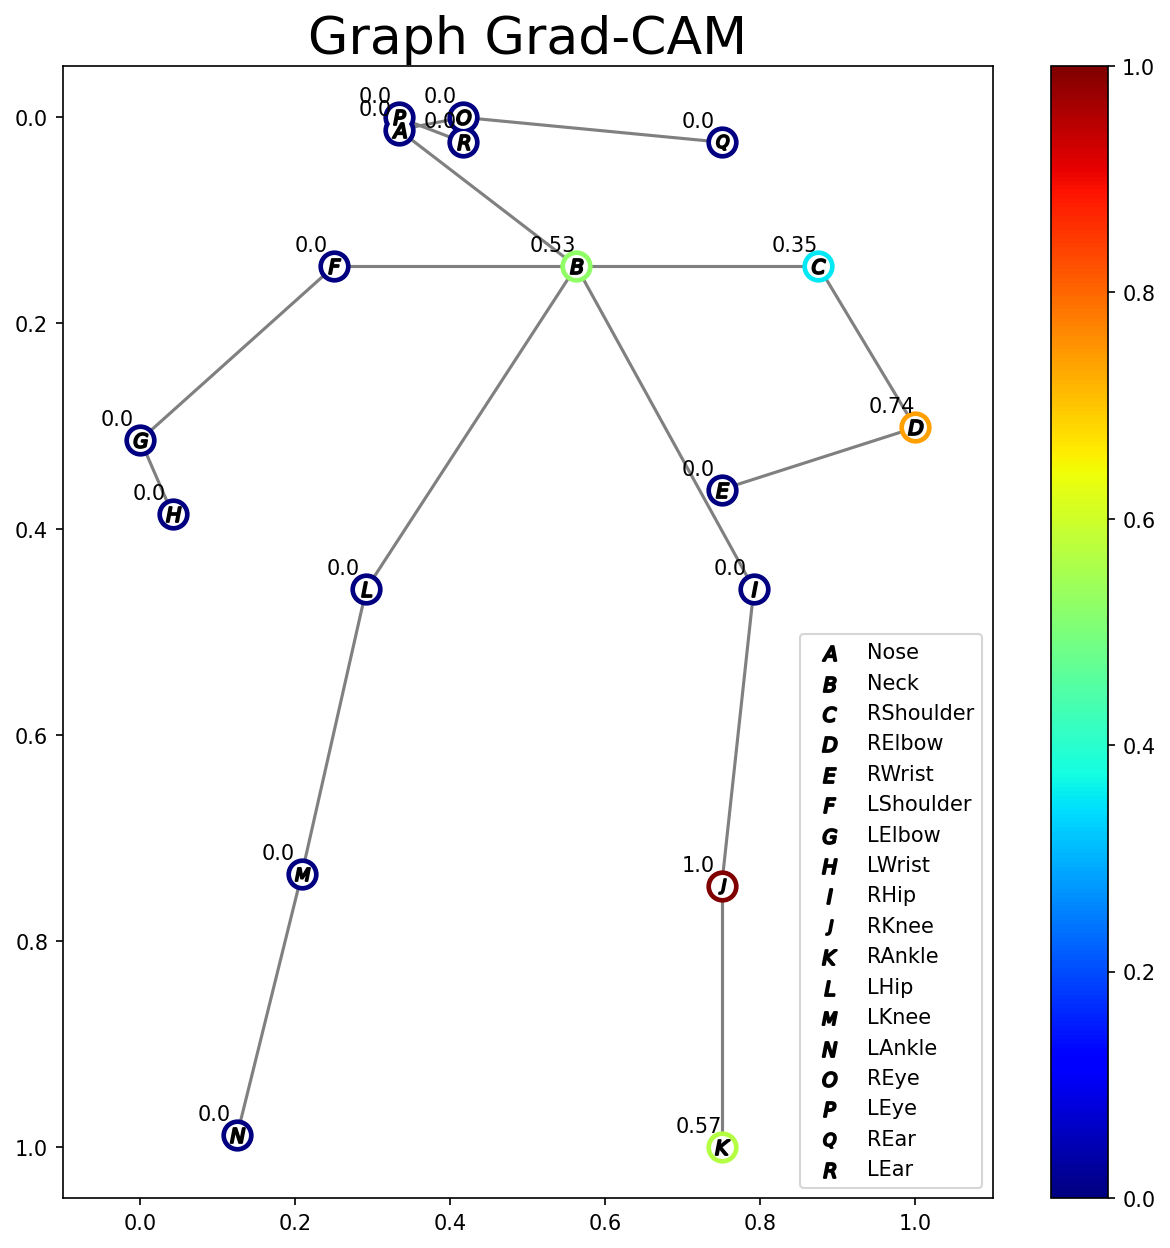

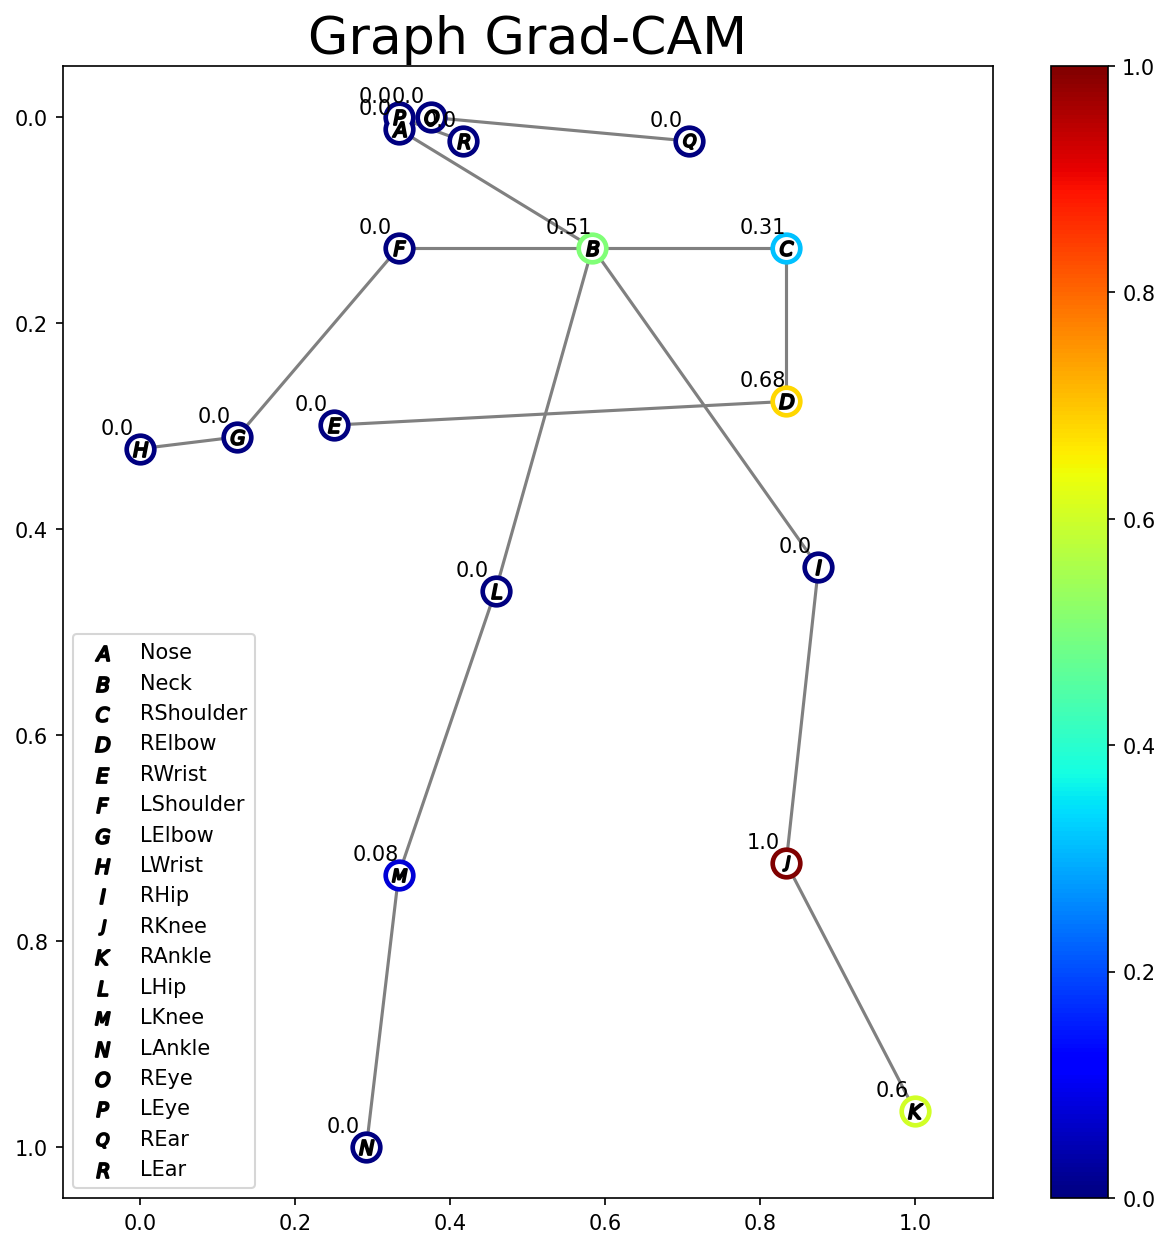

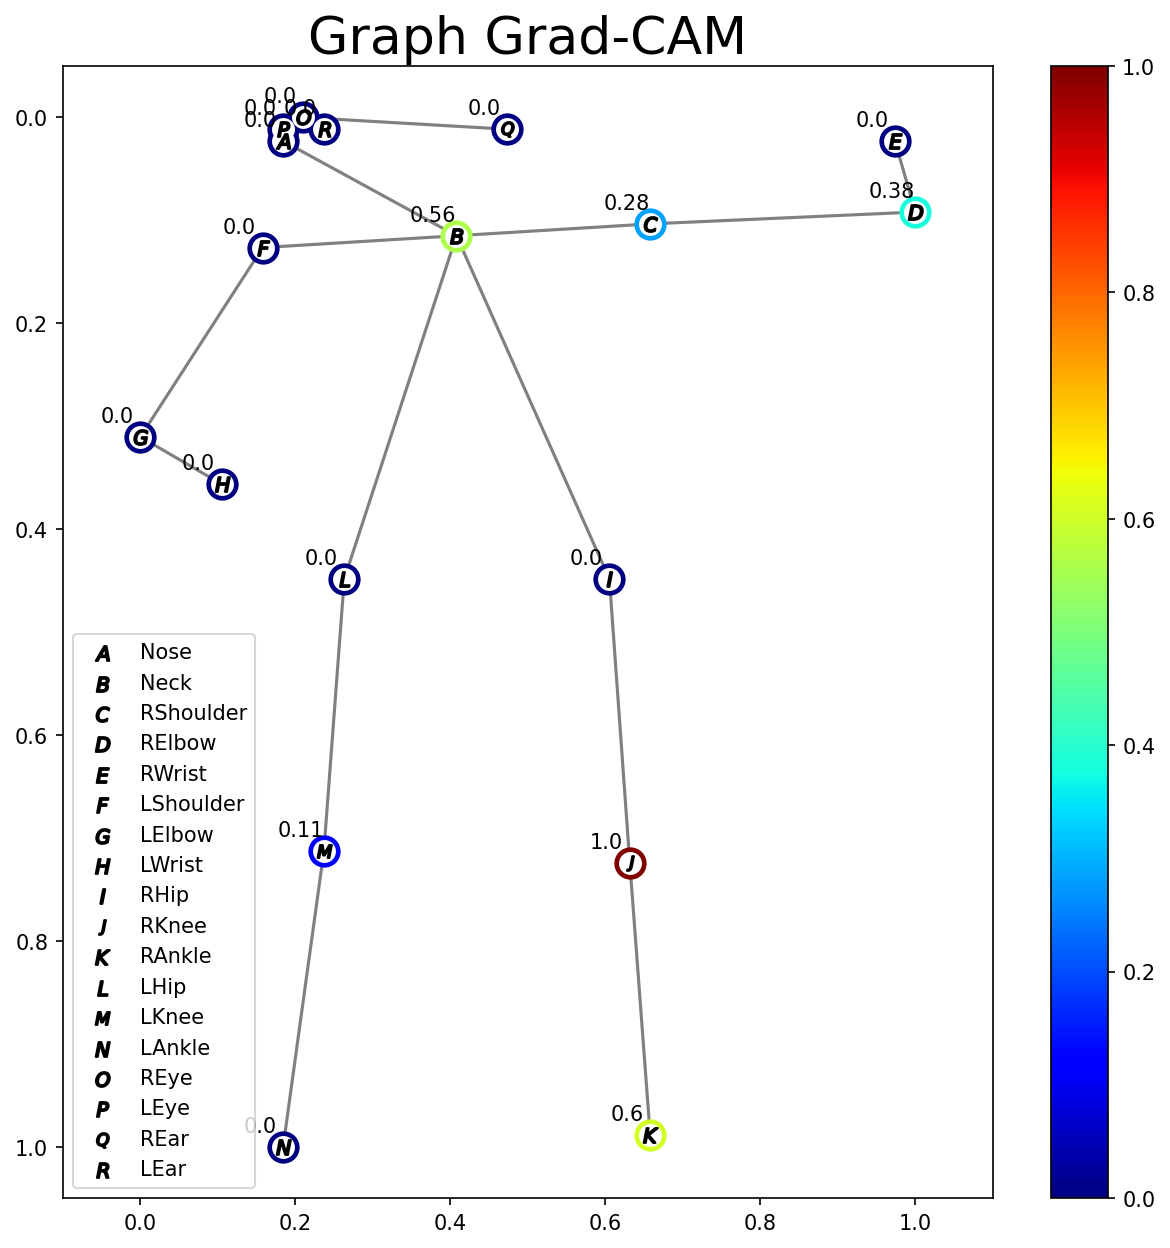

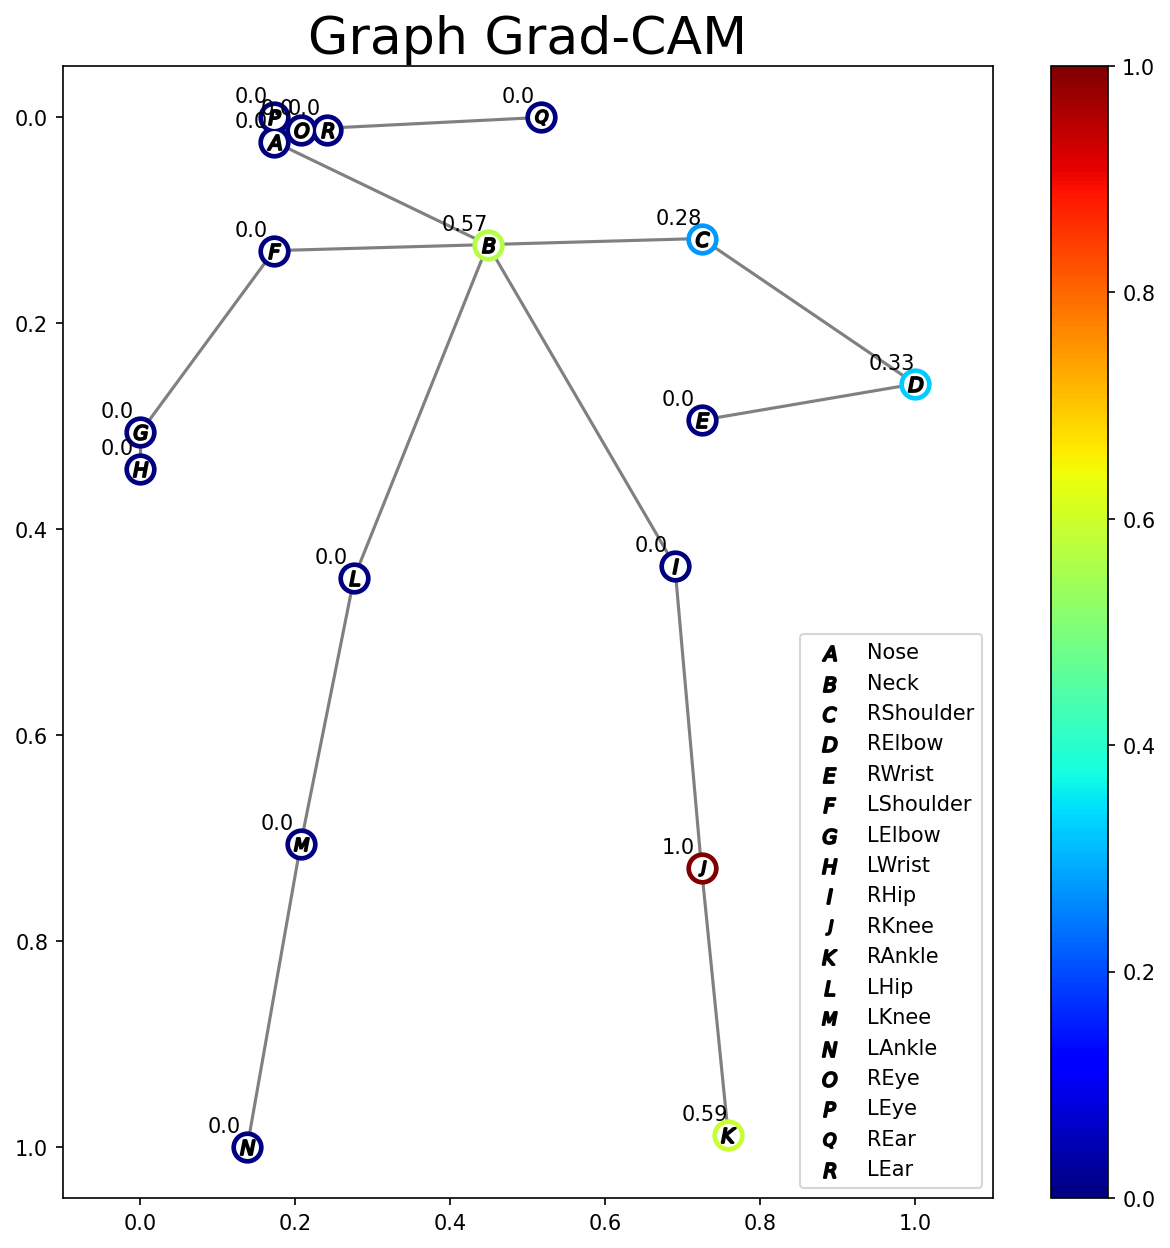

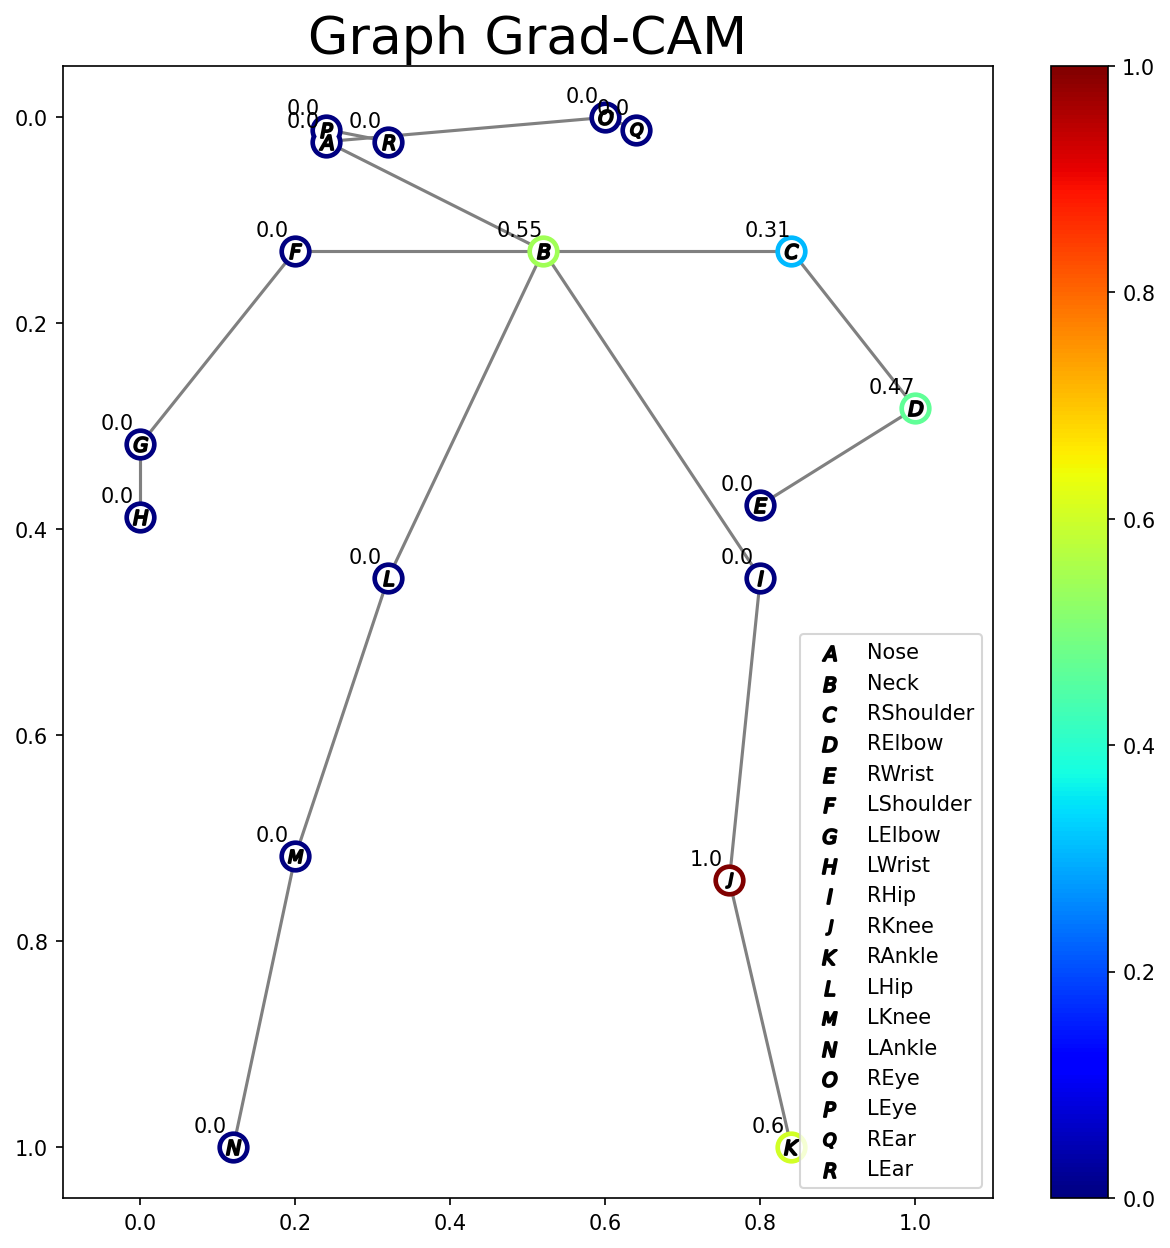

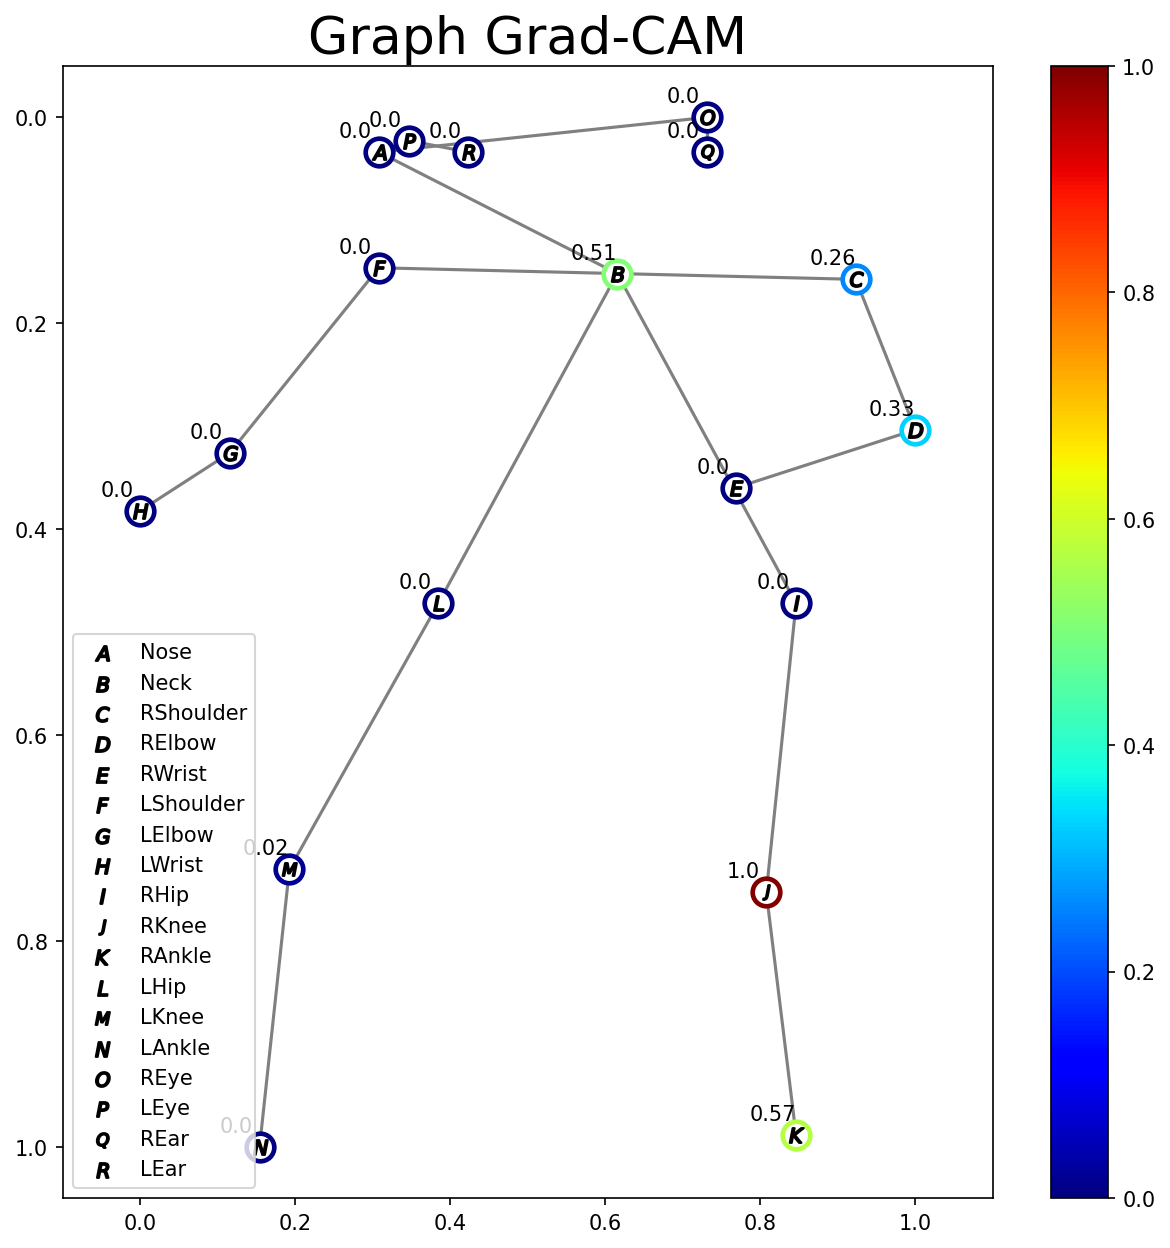

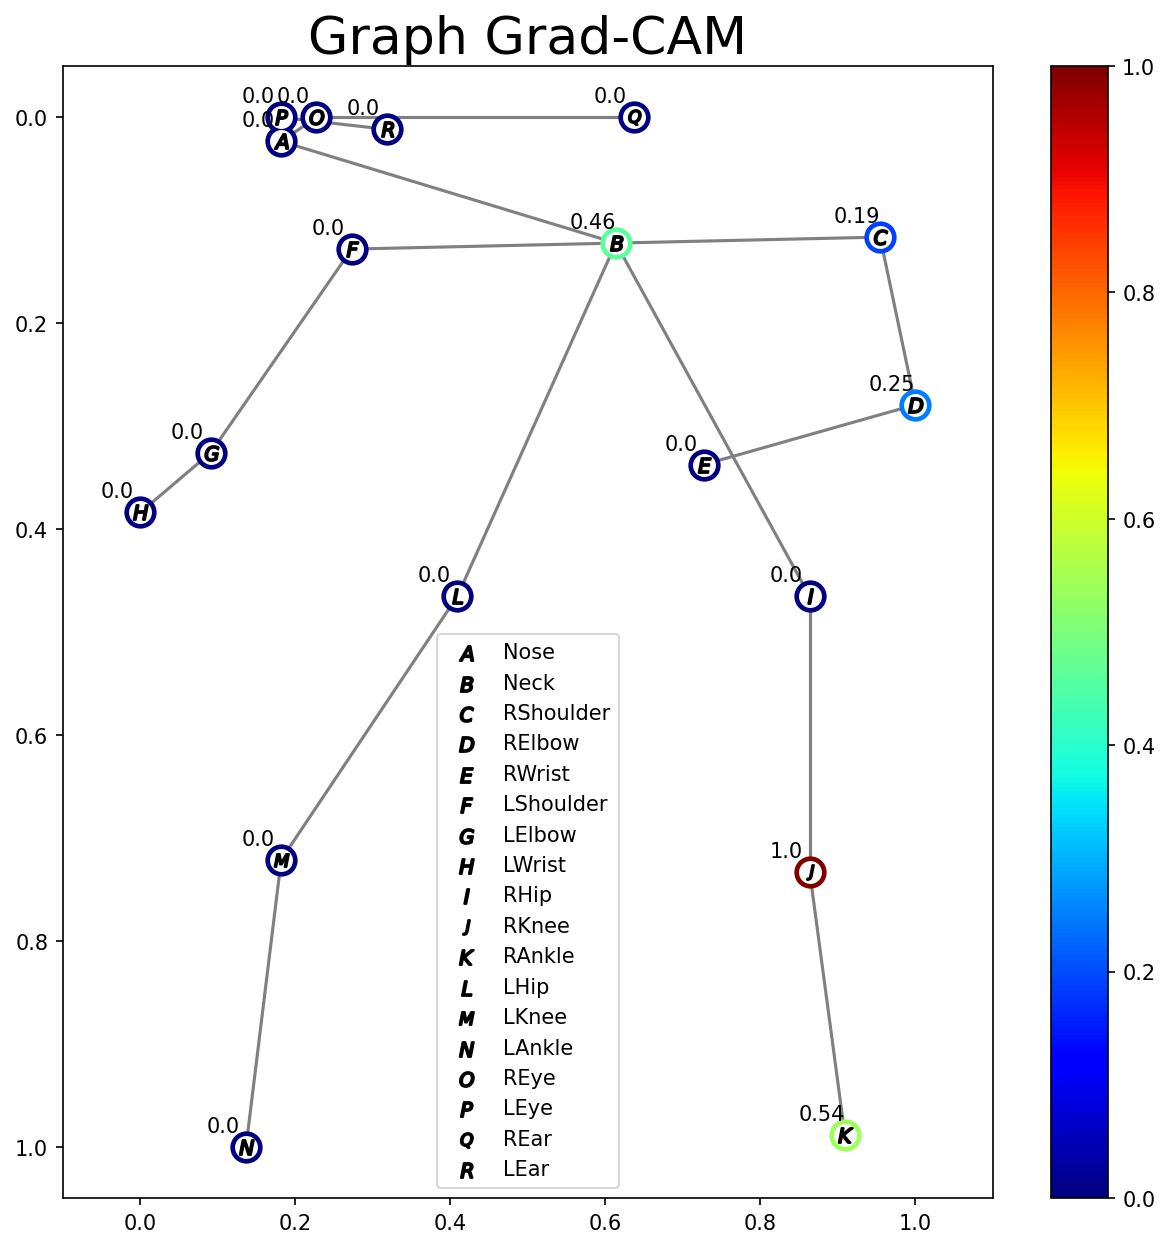

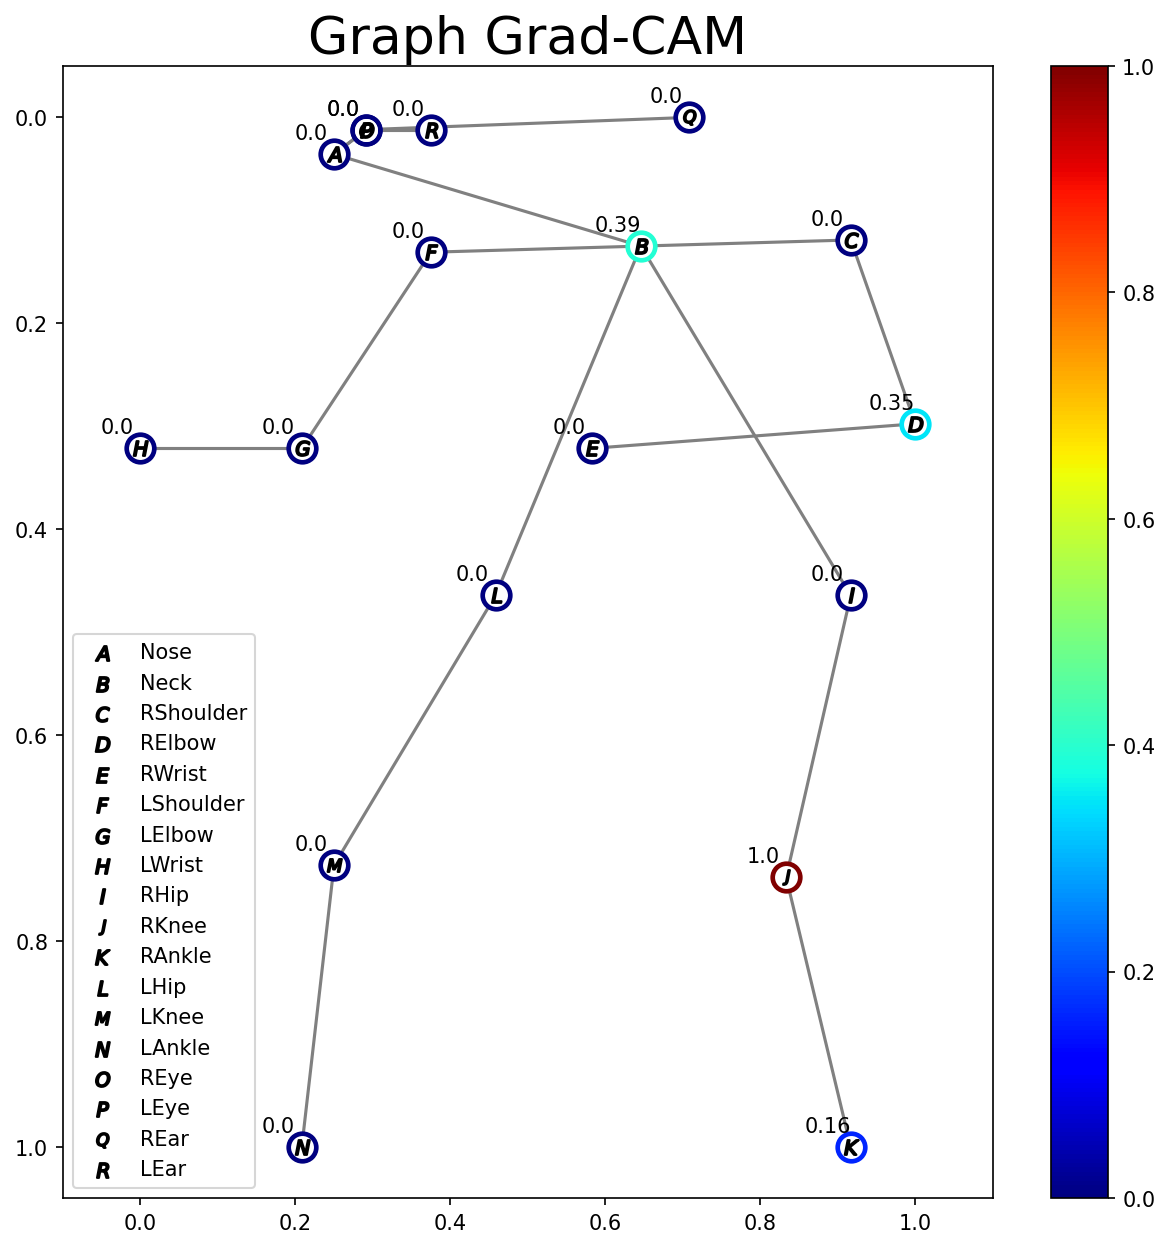

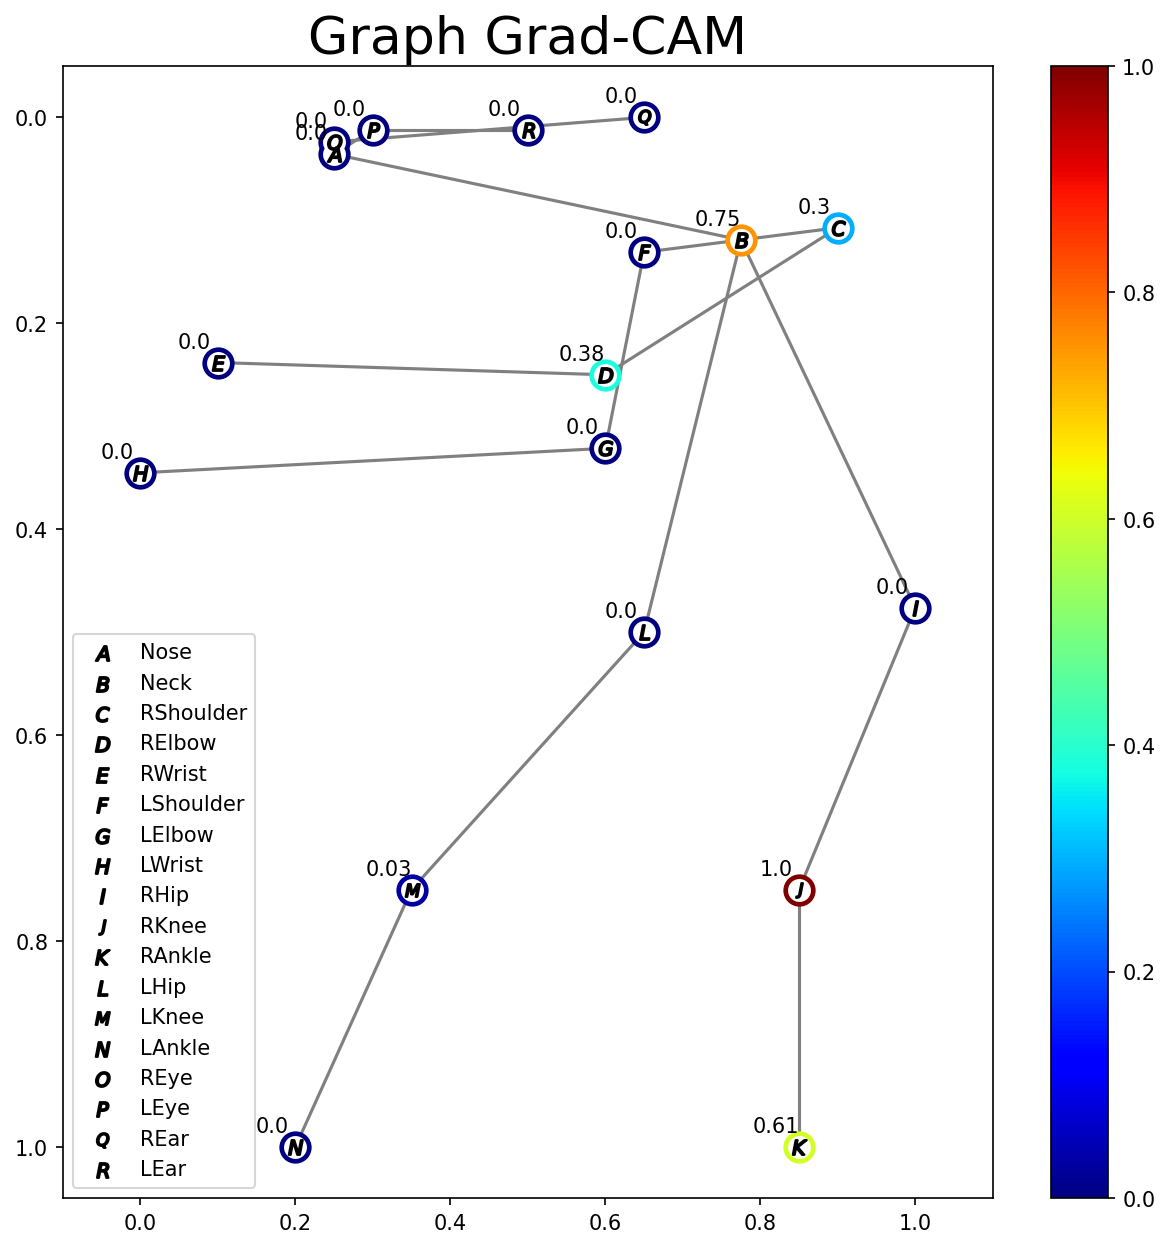

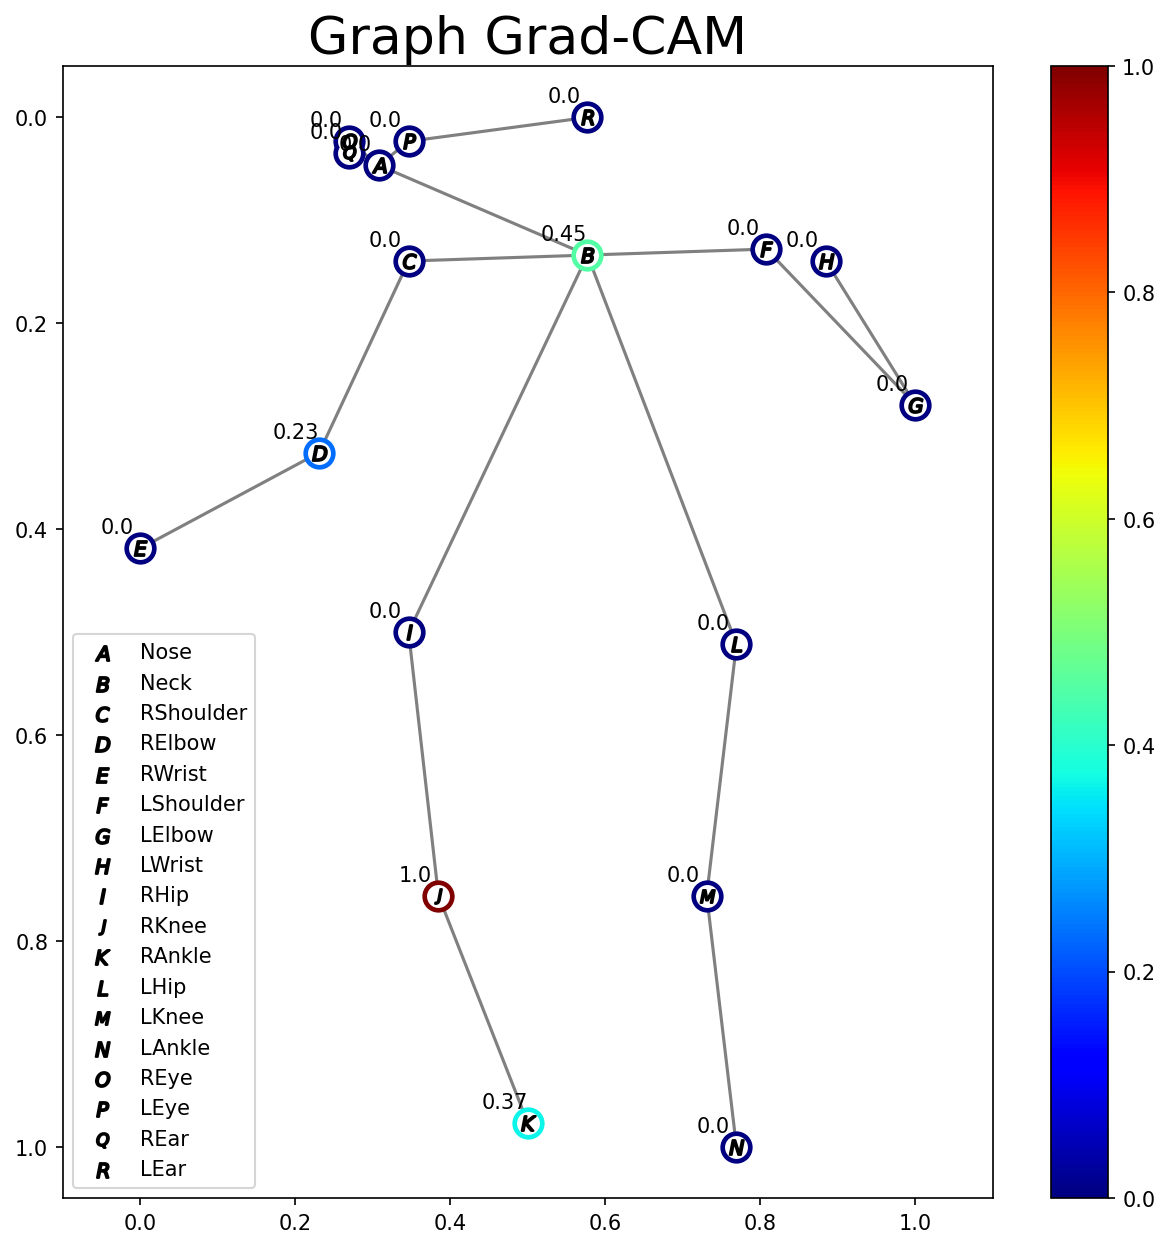

In [16]:
for s, skeleton in enumerate(skeletons[0:300:30]):
    
    show_grad_cam(s, skeleton, heatmaps)

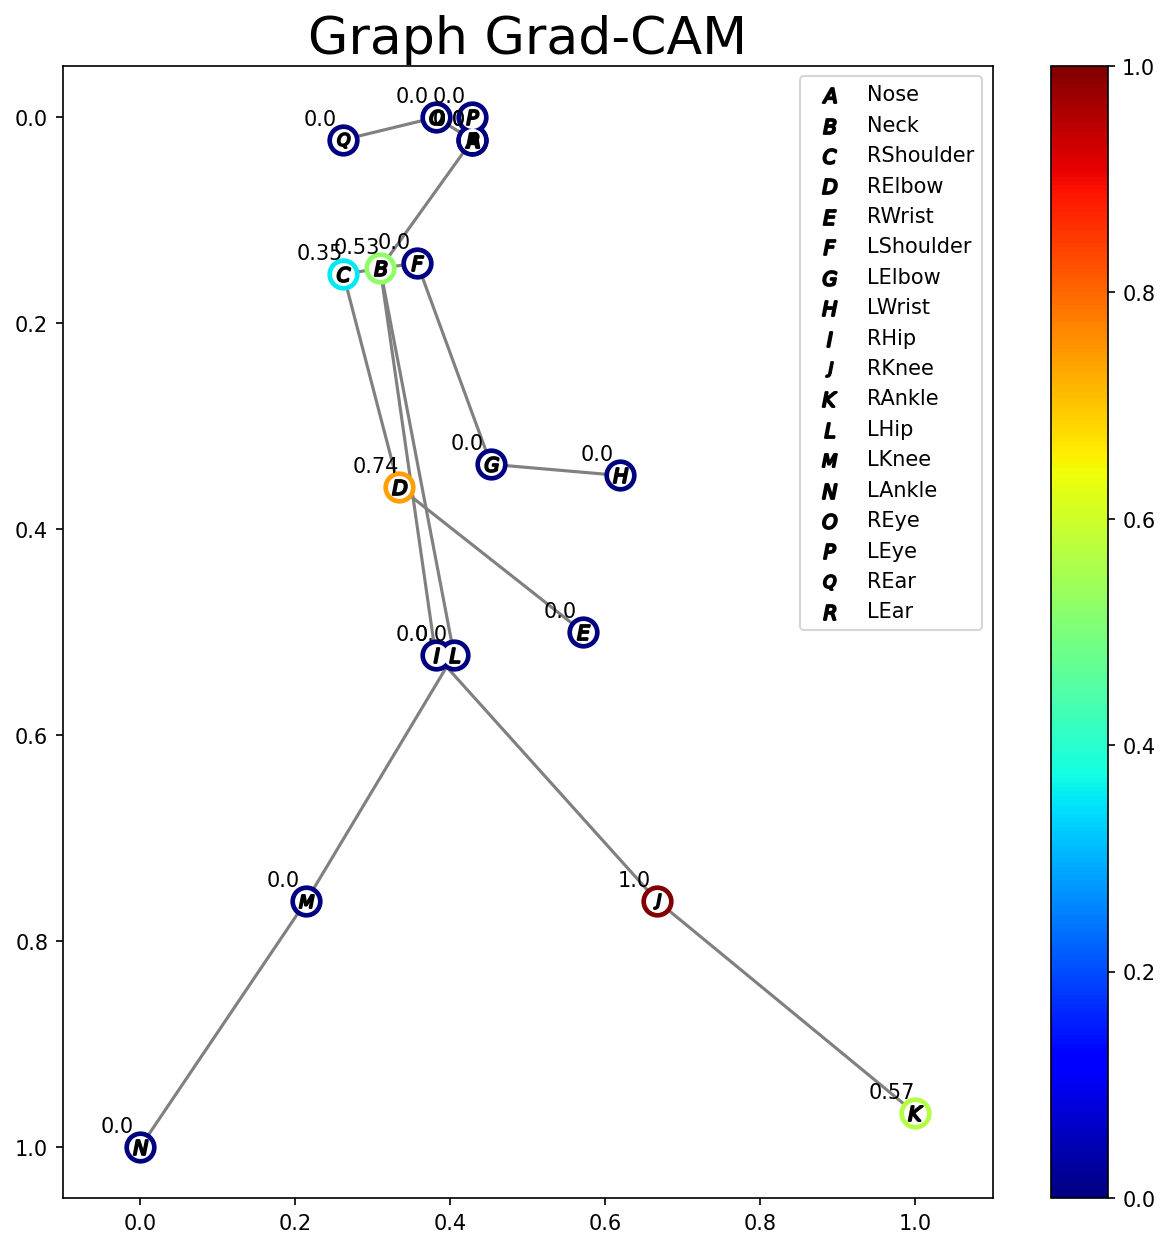

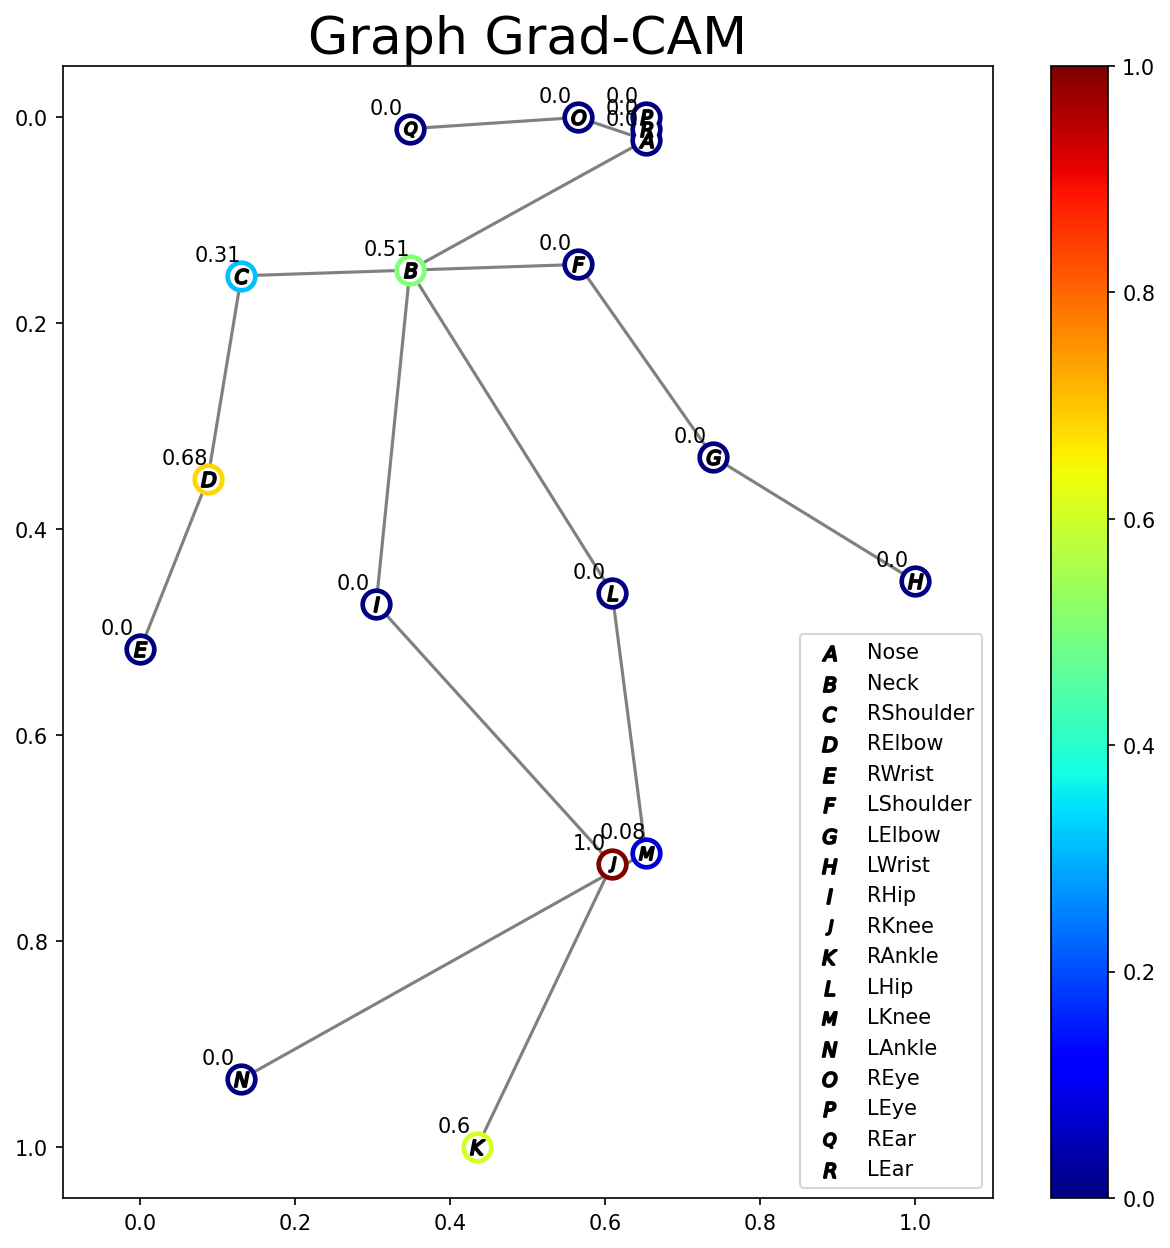

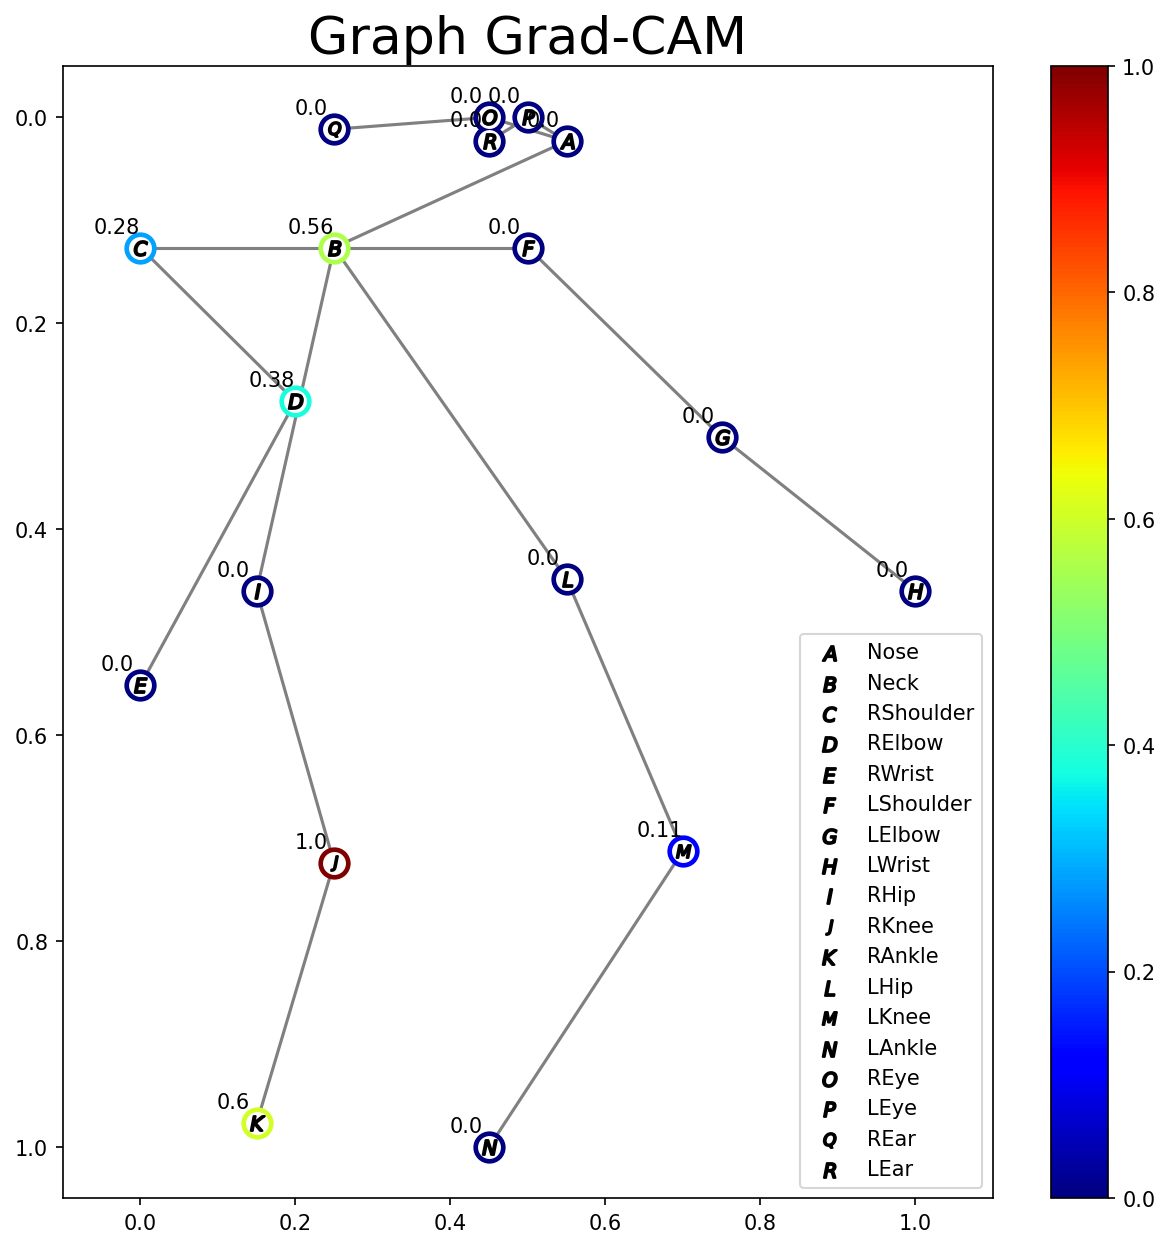

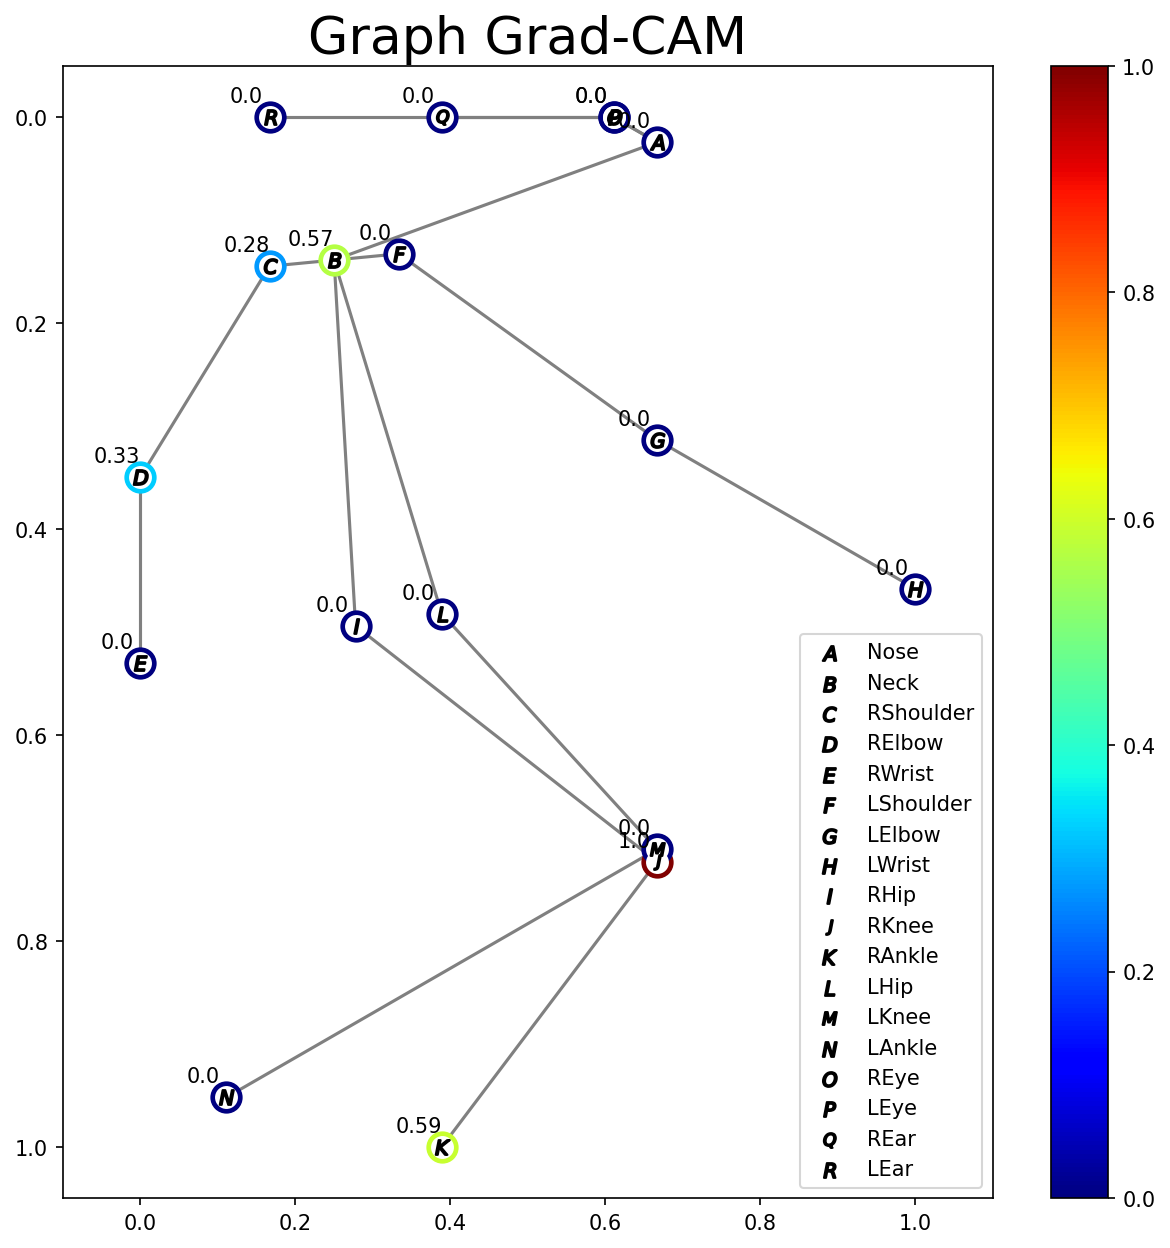

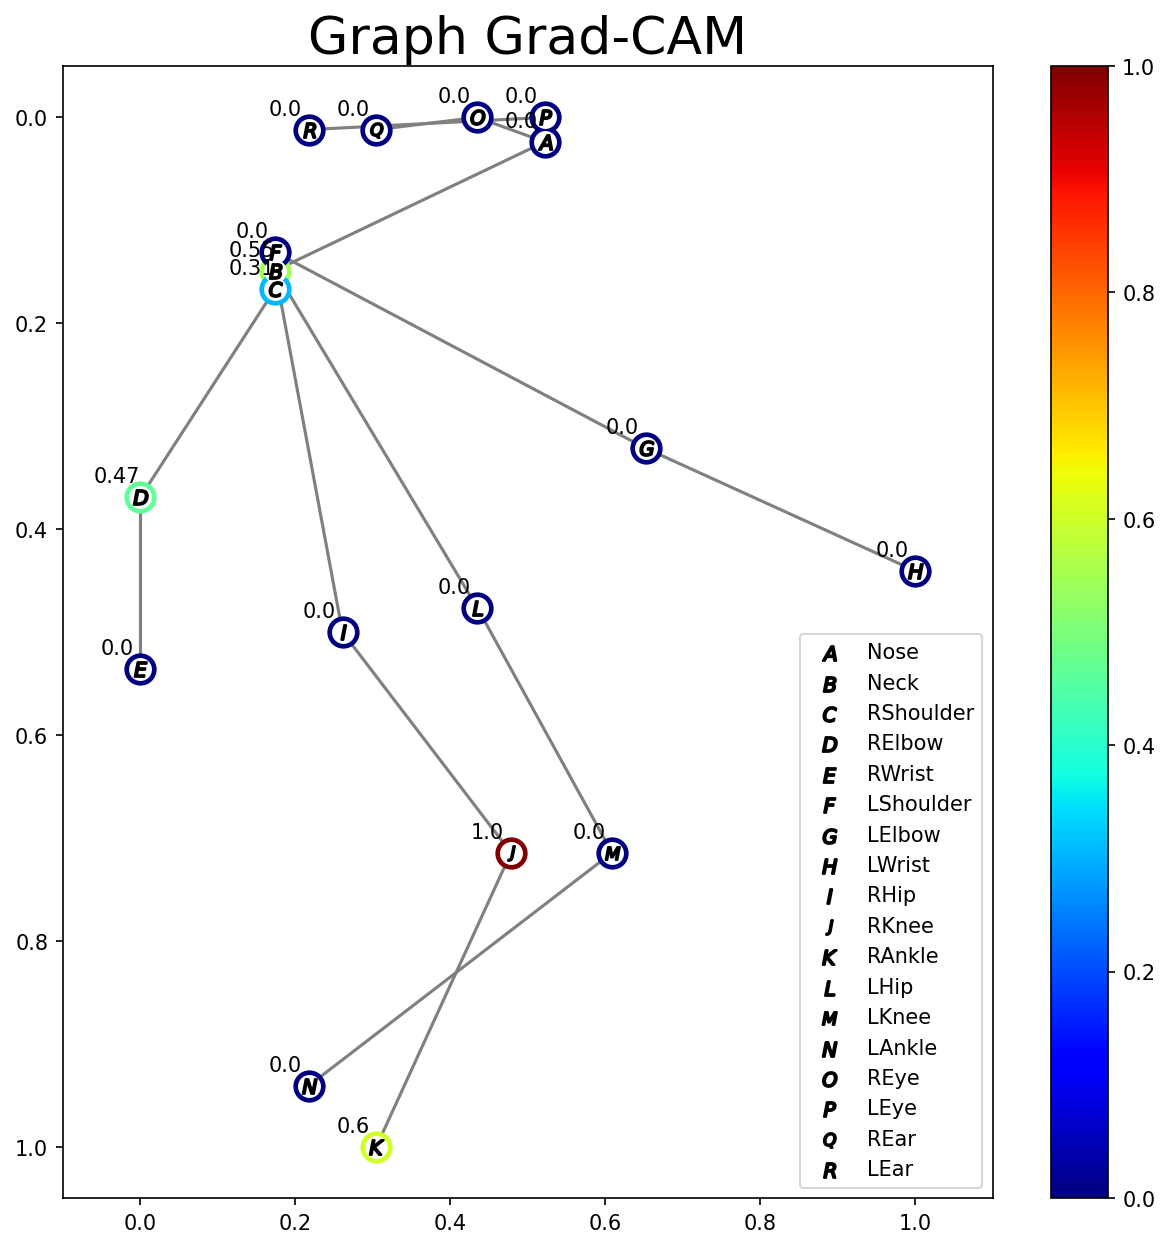

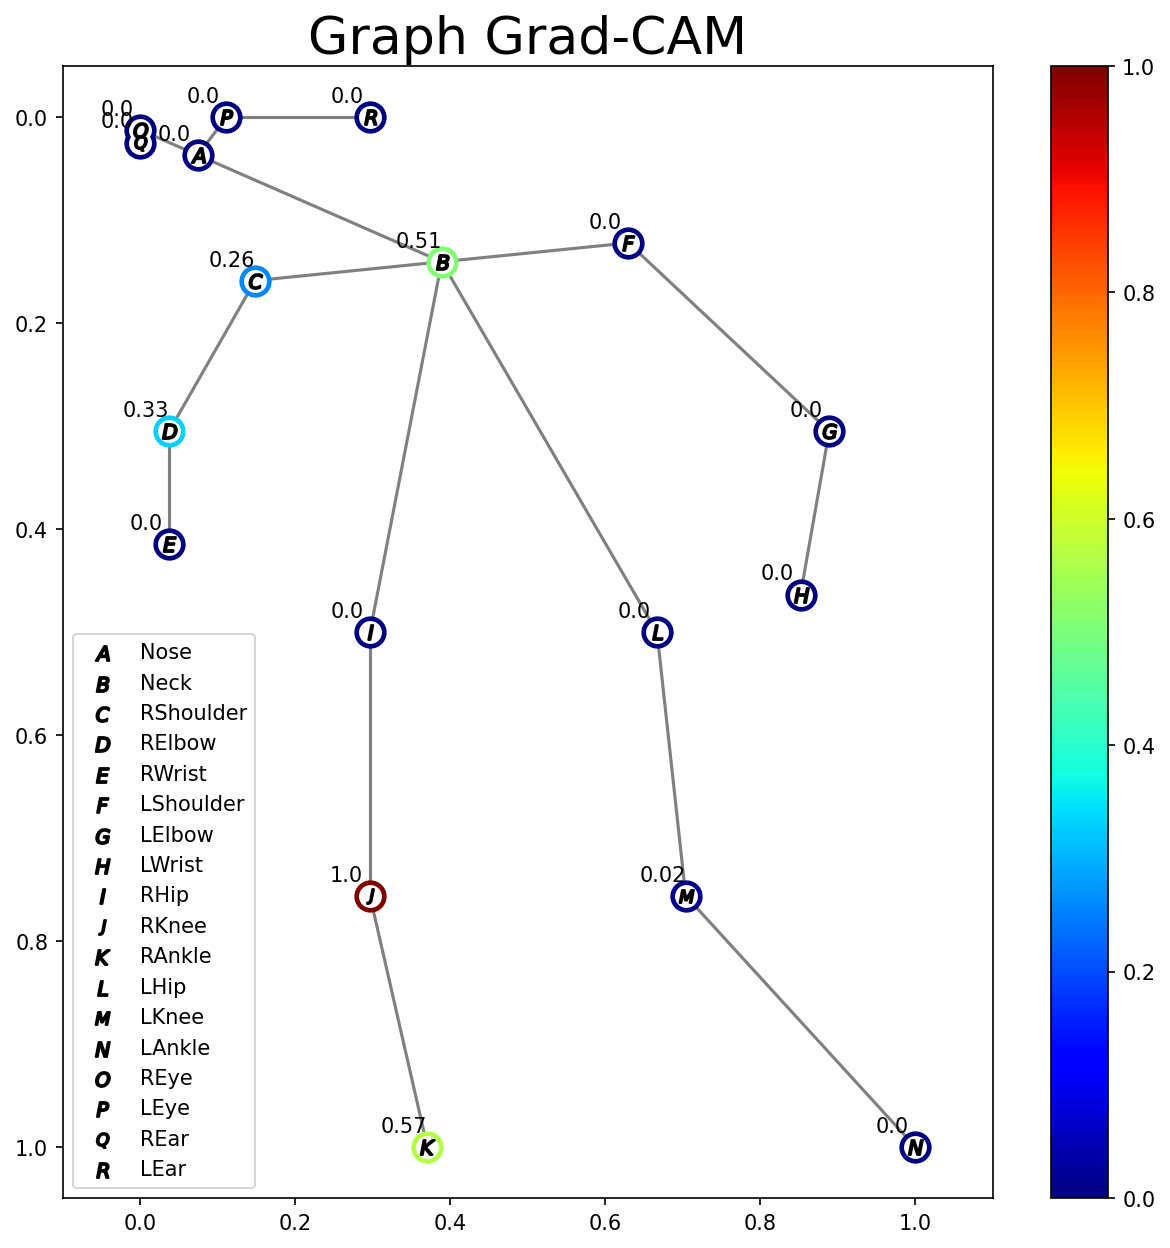

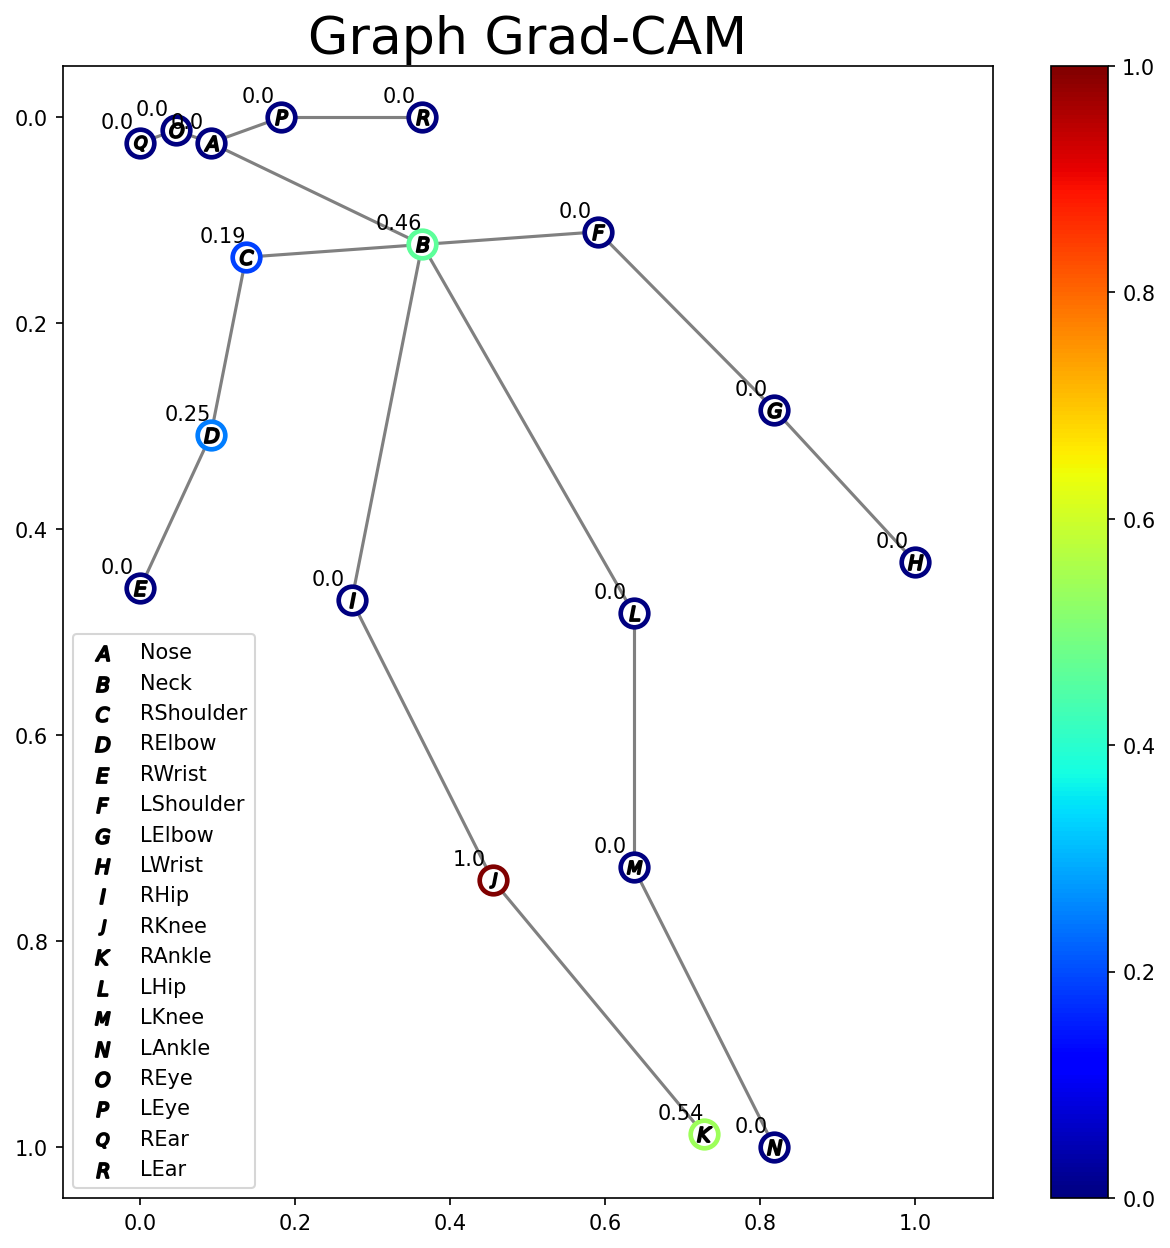

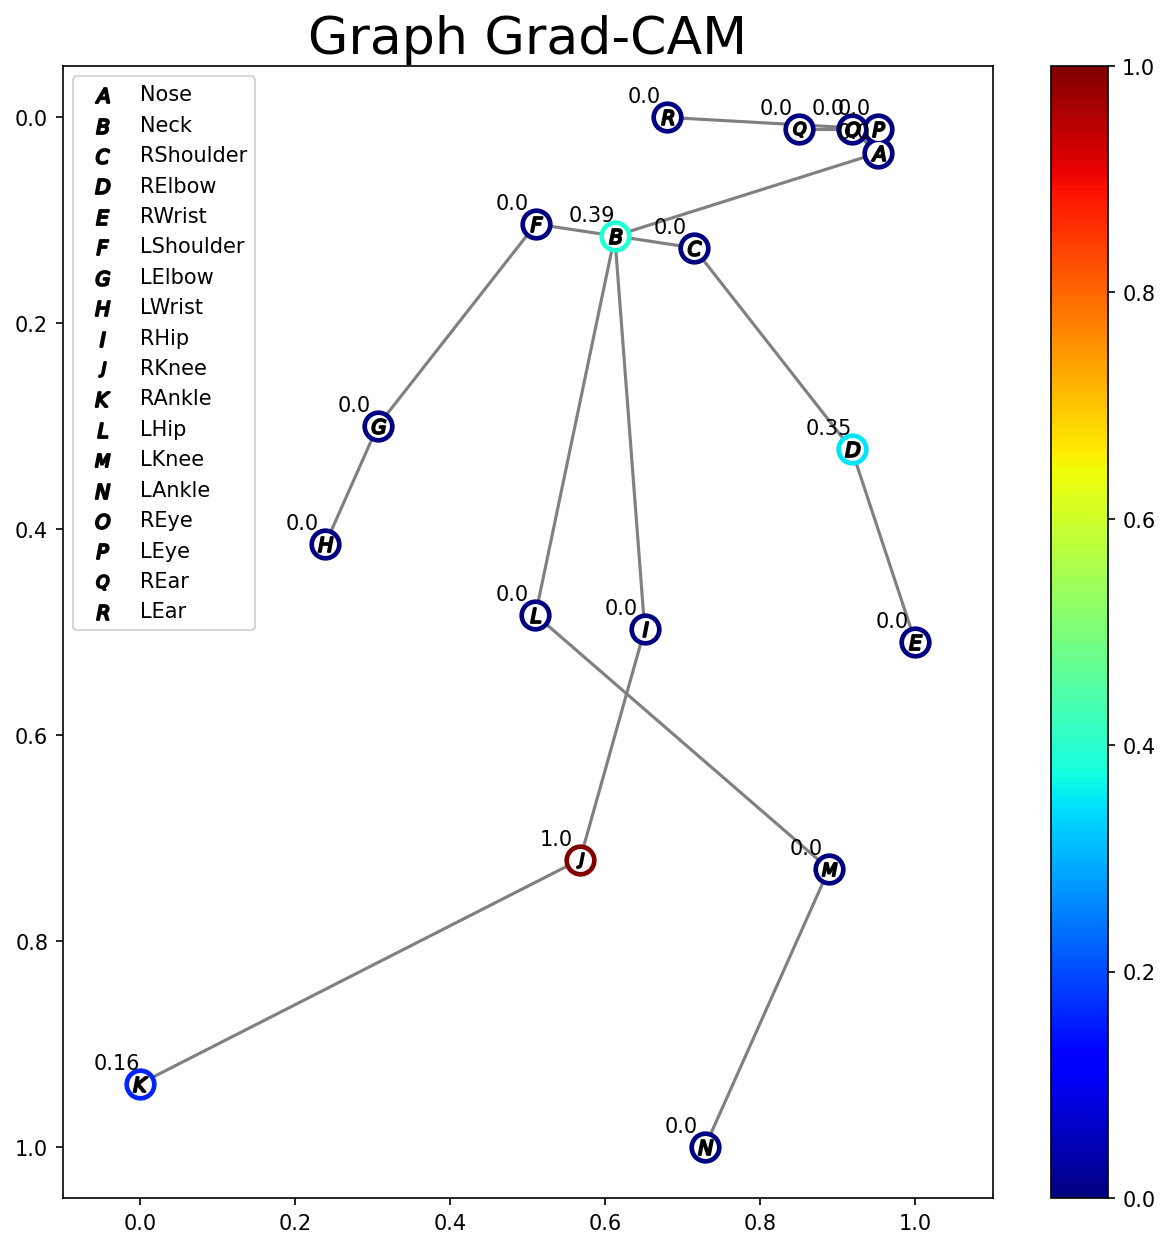

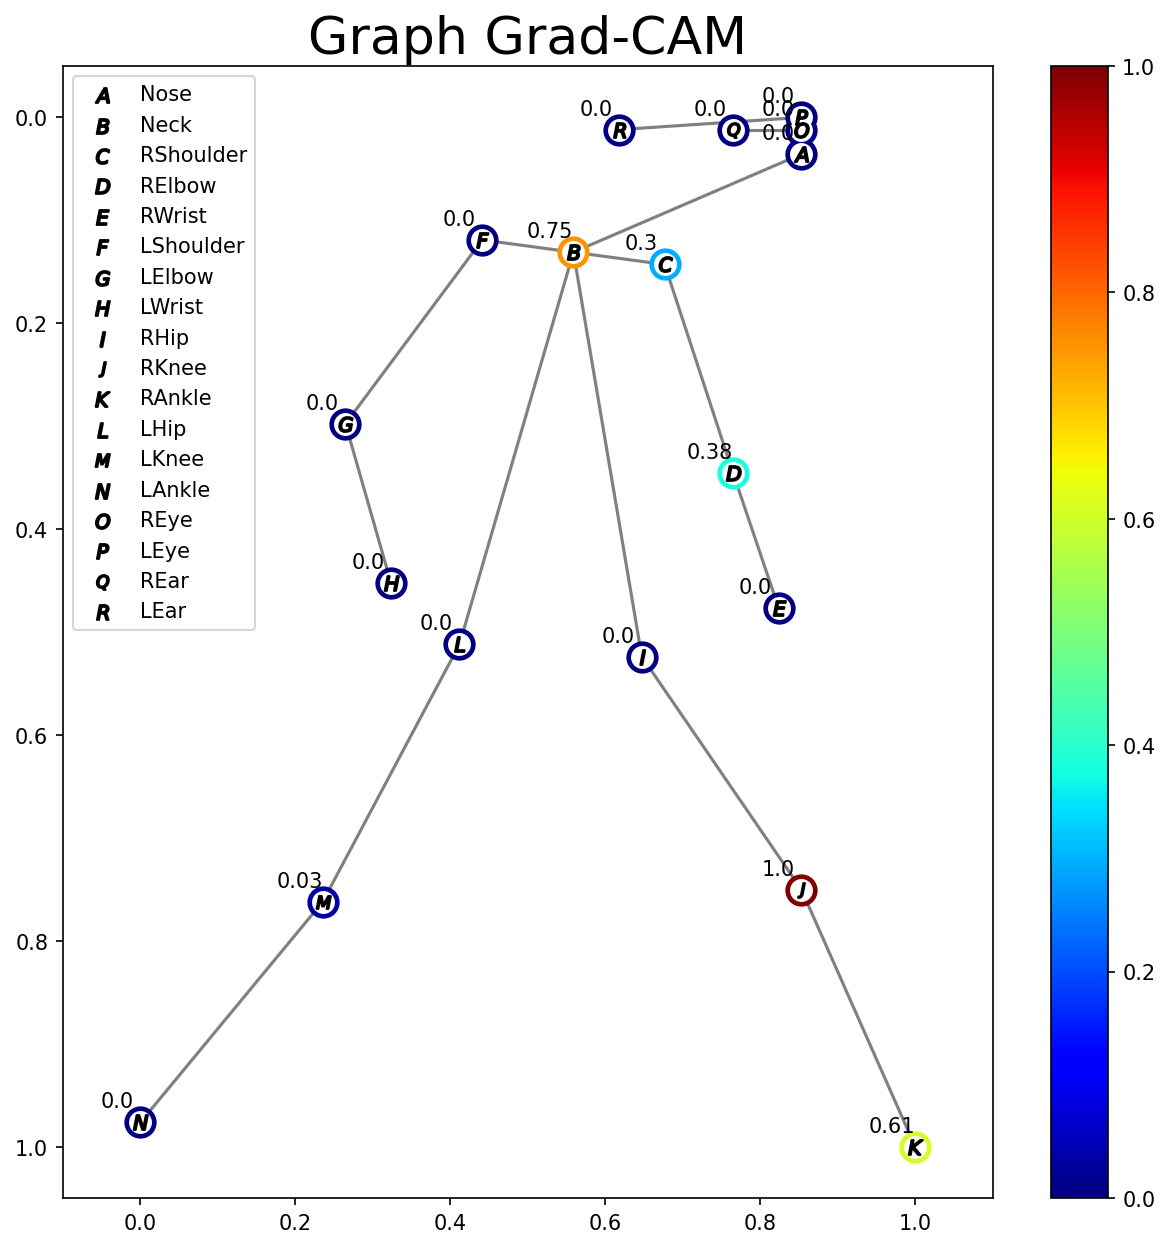

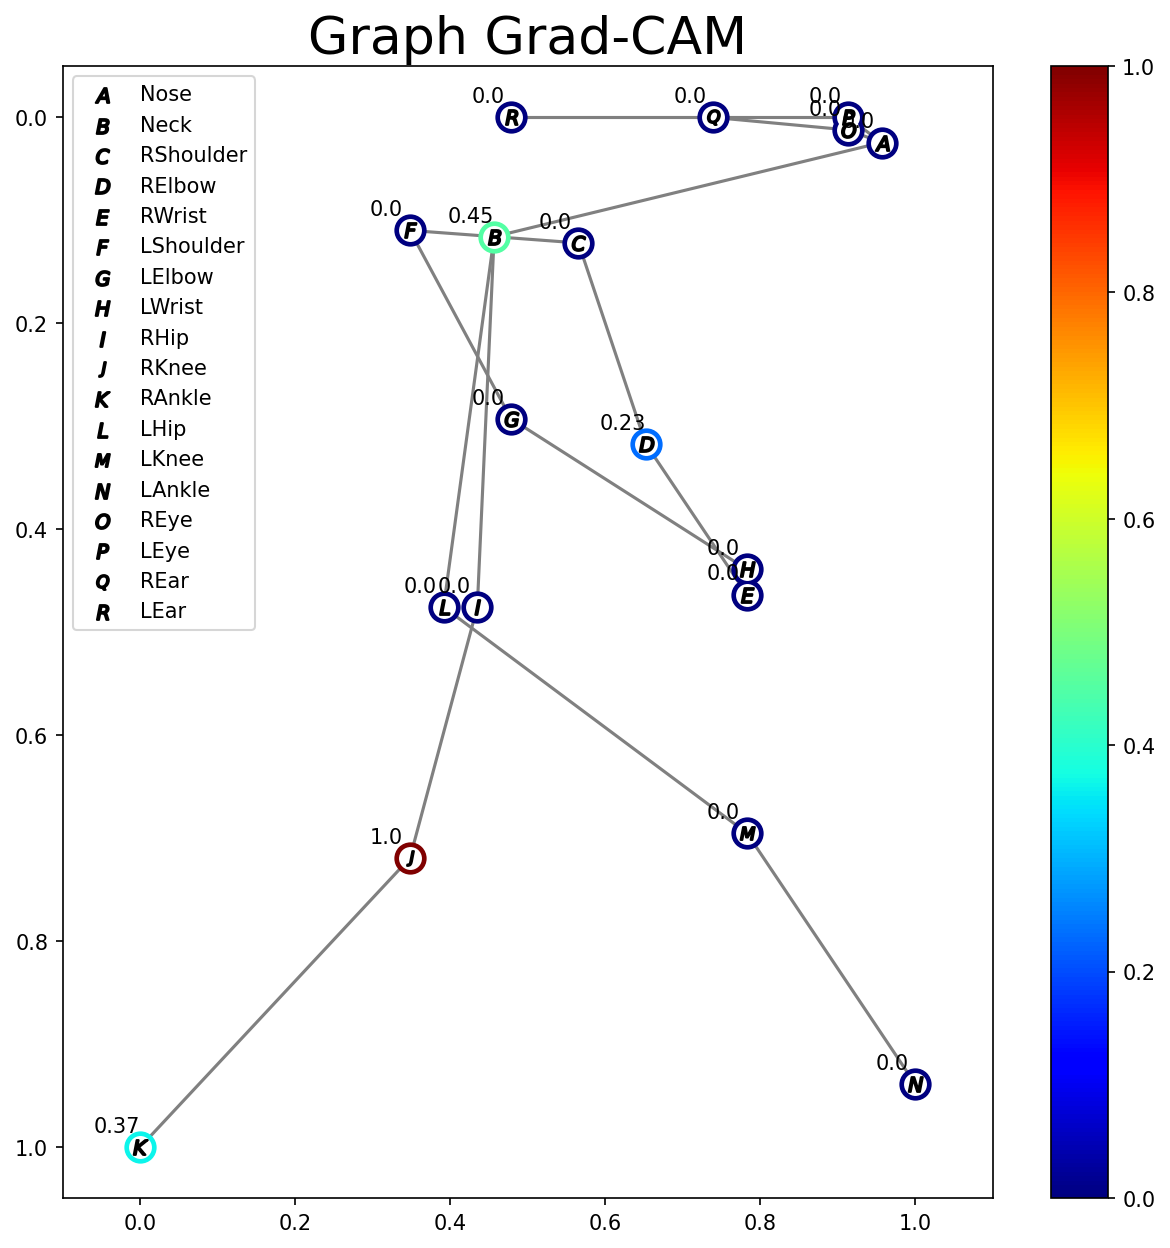

In [17]:
for s, skeleton in enumerate(skeletons[1000:1300:30]):
    
    show_grad_cam(s, skeleton, heatmaps)

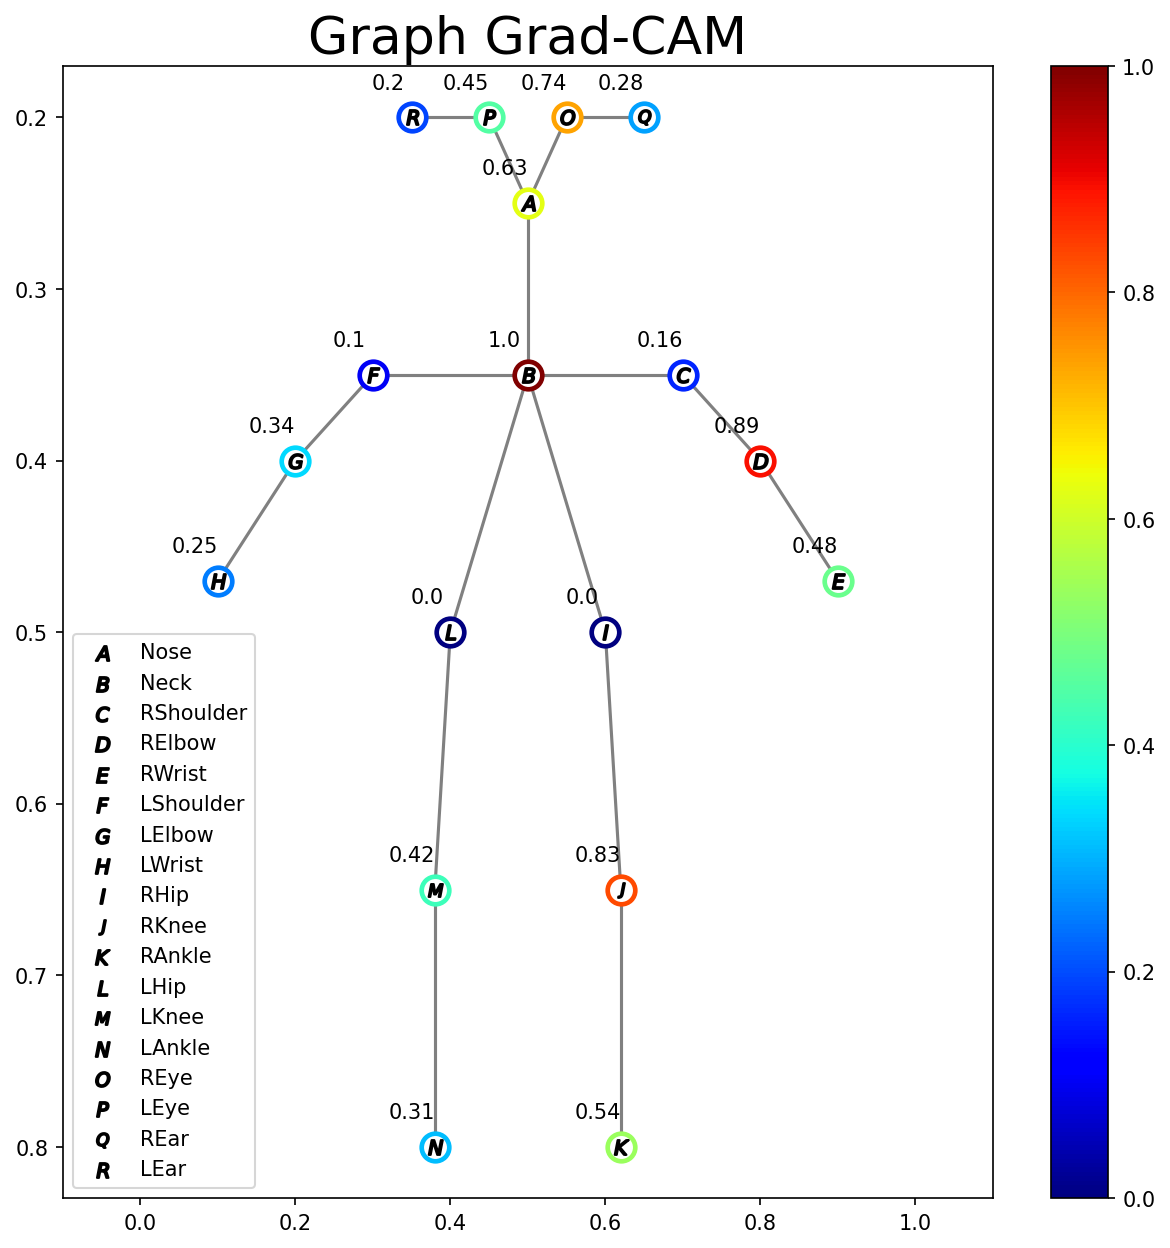

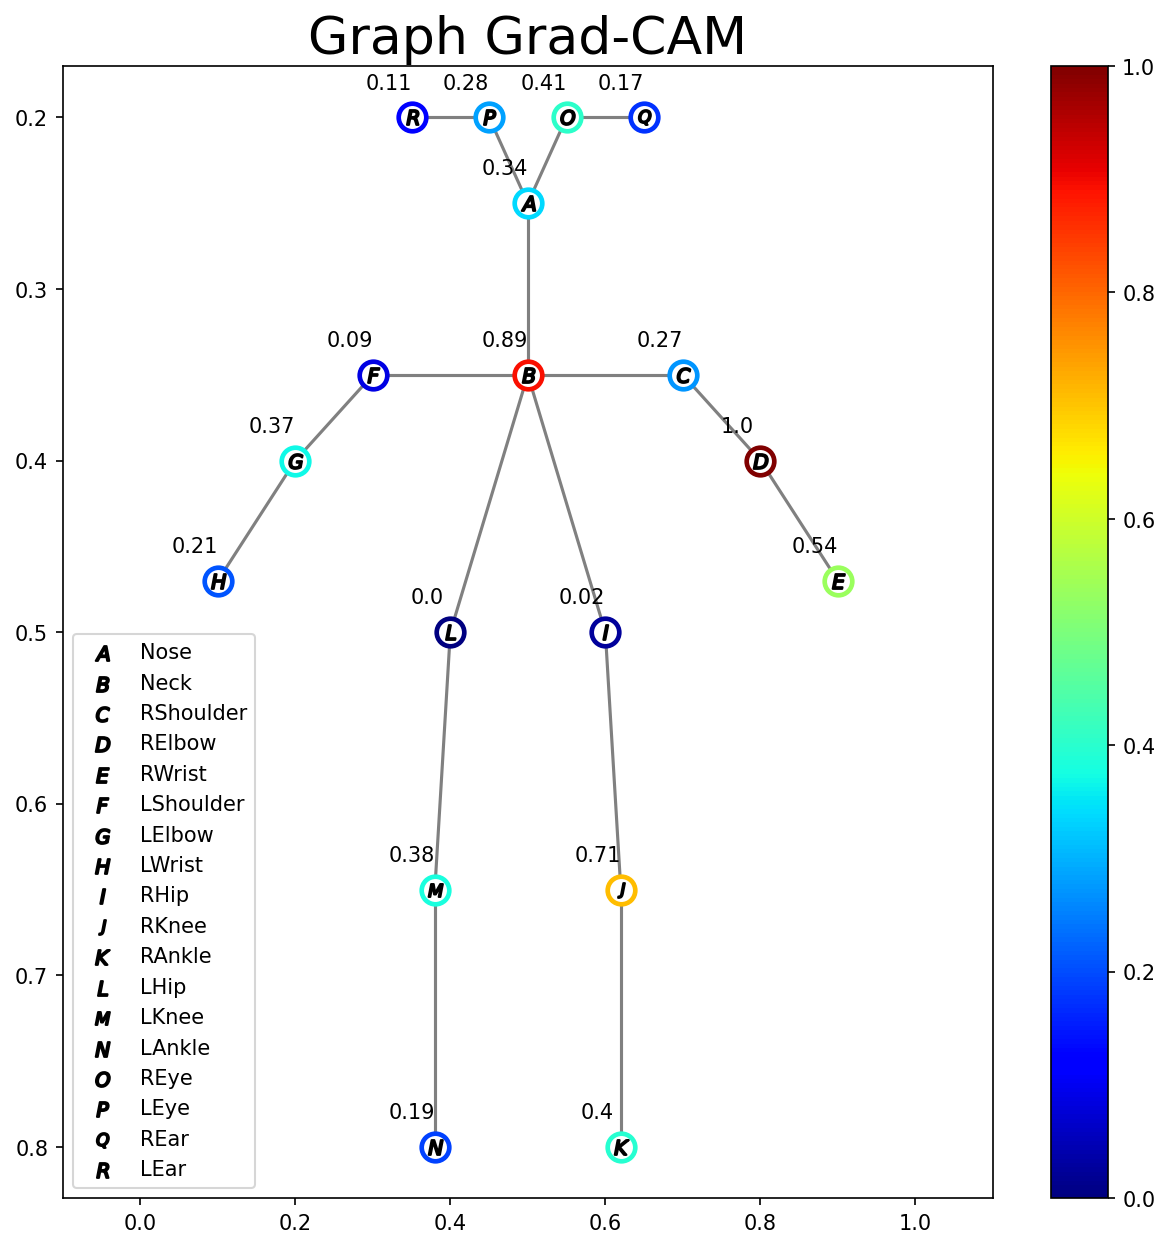

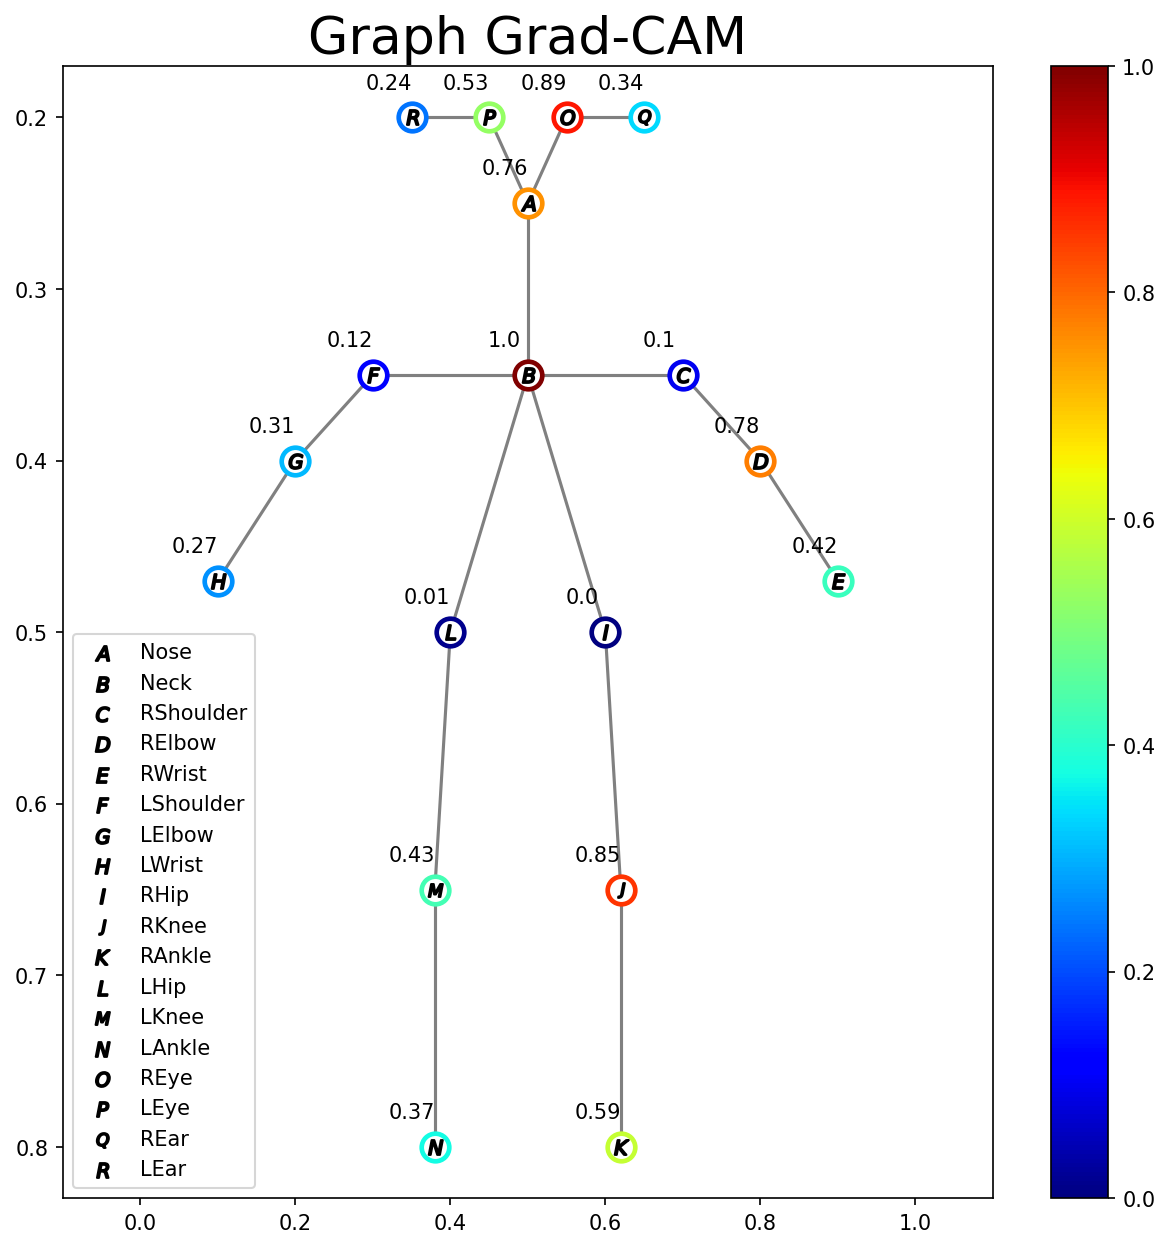

In [18]:
default_skeleton = [
    [0.5, 0.25],  # Nose
    [0.5, 0.35],  # Neck
    [0.55, 0.35],  # RShoulder
    [0.6, 0.4],  # RElbow
    [0.63, 0.47],  # RWrist
    [0.45, 0.35],  # LShoulder
    [0.4, 0.4],  # LElbow
    [0.37, 0.47],  # LWrist
    [0.55, 0.5],  # RHip
    [0.55, 0.65],  # RKnee
    [0.55, 0.8],  # RAnkle
    [0.45, 0.5],  # LHip
    [0.45, 0.65],  # LKnee
    [0.45, 0.8],  # LAnkle
    [0.52, 0.2],  # REye
    [0.48, 0.2],  # LEye
    [0.55, 0.2],  # REar
    [0.45, 0.2]  # LEar
]

default_skeleton = [
    [0.5, 0.25],  # Nose
    [0.5, 0.35],  # Neck
    [0.7, 0.35],  # RShoulder
    [0.8, 0.4],  # RElbow
    [0.9, 0.47],  # RWrist
    [0.3, 0.35],  # LShoulder
    [0.2, 0.4],  # LElbow
    [0.1, 0.47],  # LWrist
    [0.6, 0.5],  # RHip
    [0.62, 0.65],  # RKnee
    [0.62, 0.8],  # RAnkle
    [0.4, 0.5],  # LHip
    [0.38, 0.65],  # LKnee
    [0.38, 0.8],  # LAnkle
    [0.55, 0.2],  # REye
    [0.45, 0.2],  # LEye
    [0.65, 0.2],  # REar
    [0.35, 0.2]  # LEar
]

#default_skeleton = (default_skeleton - np.min(default_skeleton)) / (np.max(default_skeleton) - np.min(default_skeleton))

class_heatmaps = {}
for label, heatmap in zip(labels, heatmaps):

    if label in class_heatmaps:
        class_heatmaps[label].append(heatmap)
    else:
        class_heatmaps[label] = [heatmap]
    

show_grad_cam(0, default_skeleton, [np.mean(heatmaps, axis=0)])
show_grad_cam(0, default_skeleton, [np.mean(class_heatmaps[0], axis=0)])
show_grad_cam(0, default_skeleton, [np.mean(class_heatmaps[1], axis=0)])